# now do some ML using the web scraped data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from player_data_expansion import get_all_expanded_player_fight_data

In [3]:
# AWS integration getting file data
df_init = pd.read_csv("fight_data.csv").fillna(pd.NA)

In [4]:
df_init.head()

,Date,fighter1,fighter1_result,method_or_round,fighter2,Venue,Undercard fights,link,fighter1_record_wins,fighter1_record_draws,fighter1_record_losses,fighter2_record_wins,fighter2_record_draws,fighter2_record_losses,fighter1_height_cm,fighter2_height_cm,fighter1_ko_percentage,fighter2_ko_percentage,fighter1_debut,fighter2_debut
0,"Sunday, 4 May 2025",Naoya Inoue,Winner,"TKO, Round 8",Ramon Cardenas,"T-Mobile Arena, Las Vegas, United States",Rafael Espinoza Beat Edward Vazquez (TKO 7) \...,https://box.live/fights/inoue-vs-cardenas/,29,0,0,26,0,1,164,168.0,0,0,2012,2015
1,"Saturday, 3 May 2025",Canelo Alvarez,Winner,"UD, Round 12",William Scull,"The Venue, Riyadh, Saudi Arabia",Jaime Munguia Beat Bruno Surace (UD 12) \nMar...,https://box.live/fights/canelo-vs-scull/,62,2,2,23,0,0,175,182.0,0,0,2005,2016
2,"Saturday, 3 May 2025",Jukiya Iimura,Winner,"UD, Round 12",Esneth Domingo,"Korakuen Hall, Tokyo, Japan",<NA>,https://box.live/fights/iimura-vs-domingo/,8,0,1,21,0,2,164,160.0,0,0,2021,2015
3,"Friday, 2 May 2025",Ryan Garcia,Loser,"UD, Round 12",Rolando ‘Rolly’ Romero,"Times Square, New York, NY, United States",Devin Haney Beat Jose Ramirez (UD 12) \nTeofi...,https://box.live/fights/garcia-vs-romero/,24,0,1,16,0,2,178,173.0,83,81,2016,2016
4,"Thursday, 1 May 2025",Kevin Lerena,Winner,"TKO, Round 3",Serhiy Radchenko,"Sunbet Arena, Pretoria, South Africa",<NA>,https://box.live/fights/lerena-vs-radchenko/,30,0,3,11,0,7,185,186.0,47,45,2011,2014


In [5]:
df_init.tail()

,Date,fighter1,fighter1_result,method_or_round,fighter2,Venue,Undercard fights,link,fighter1_record_wins,fighter1_record_draws,fighter1_record_losses,fighter2_record_wins,fighter2_record_draws,fighter2_record_losses,fighter1_height_cm,fighter2_height_cm,fighter1_ko_percentage,fighter2_ko_percentage,fighter1_debut,fighter2_debut
7,"Sunday, 20 April 2025",Ben Whittaker,Winner,"TKO, Round 2",Liam Cameron,"Resorts World Arena, Birmingham, United Kingdom",Sam Eggington Beat Lee Cutler (TD 9) \nFrazer...,https://box.live/fights/whittaker-vs-cameron-ii/,8,1,0,23,1,6,191,183.0,63,43,2022,2009
8,"Saturday, 19 April 2025",Dalton Smith,Winner,"UD, Round 12",Mathieu Germain,"Park Community Arena, Sheffield, United Kingdom",Caoimhin Agyarko Beat Ryan Kelly (MD 10) \nJo...,https://box.live/fights/smith-vs-germain/,17,0,0,26,1,2,176,NaN,0,0,2019,2015
9,"Saturday, 19 April 2025",Gabriela Fundora,Winner,"TKO, Round 7",Marilyn Badillo Amaya,"Frontwave Arena, Oceanside, CA, United States",Jorge Perez Beat Charles Conwell (SD 12) \nOl...,https://box.live/fights/fundora-vs-amaya/,15,0,0,19,1,0,175,160.0,0,0,2021,2017
10,"Saturday, 19 April 2025",Sadriddin Akhmedov,Draw,"MD, Round 10",Elias Espadas,"Commerce Casino, Commerce, CA, United States",<NA>,https://box.live/fights/akhmedov-vs-espadas/,15,0,0,23,0,6,175,178.0,0,0,2018,2012
11,"Friday, 18 April 2025",Sergey Kovalev,Winner,"KO, Round 7",Artur Mann,"Yunost Arena, Chelyabinsk, Russian Federation",<NA>,https://box.live/fights/kovalev-vs-mann/,35,1,5,22,0,4,183,185.0,83,59,2009,2015


In [6]:
# ADD BASIC DATA TO SEE IF IT WORKS
df_init = pd.concat([pd.read_csv("fight_data_backup_basic.csv"), df_init], axis=0)
df_init.drop_duplicates(inplace=True)

### start cleaning

In [7]:
df_essentials = df_init.drop(columns=['link','Venue','Date','Undercard fights','fighter1','fighter2'])
df_essentials.head(2)

,fighter1_result,method_or_round,fighter1_record_wins,fighter1_record_draws,fighter1_record_losses,fighter2_record_wins,fighter2_record_draws,fighter2_record_losses,fighter1_height_cm,fighter2_height_cm,fighter1_ko_percentage,fighter2_ko_percentage,fighter1_debut,fighter2_debut
0,Winner,"RTD, Round 3",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Winner,"UD, Round 12",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df_staged_cleaning = df_essentials.copy()
df_staged_cleaning.head(2)

,fighter1_result,method_or_round,fighter1_record_wins,fighter1_record_draws,fighter1_record_losses,fighter2_record_wins,fighter2_record_draws,fighter2_record_losses,fighter1_height_cm,fighter2_height_cm,fighter1_ko_percentage,fighter2_ko_percentage,fighter1_debut,fighter2_debut
0,Winner,"RTD, Round 3",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Winner,"UD, Round 12",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df_staged_cleaning['method_or_round'] = df_staged_cleaning['method_or_round'].str.split(' ')

In [10]:
last_rounds = [new_list[2] for new_list in df_staged_cleaning['method_or_round']][:]
# df_staged_cleaning['round'] = last_rounds round includes test bias

df_staged_cleaning.head()

,fighter1_result,method_or_round,fighter1_record_wins,fighter1_record_draws,fighter1_record_losses,fighter2_record_wins,fighter2_record_draws,fighter2_record_losses,fighter1_height_cm,fighter2_height_cm,fighter1_ko_percentage,fighter2_ko_percentage,fighter1_debut,fighter2_debut
0,Winner,"[RTD,, Round, 3]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Winner,"[UD,, Round, 12]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Winner,"[TKO,, Round, 2]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Winner,"[UD,, Round, 12]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Winner,"[TKO,, Round, 7]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df_staged_cleaning = df_staged_cleaning.drop(columns='method_or_round')
df_staged_cleaning.head()

,fighter1_result,fighter1_record_wins,fighter1_record_draws,fighter1_record_losses,fighter2_record_wins,fighter2_record_draws,fighter2_record_losses,fighter1_height_cm,fighter2_height_cm,fighter1_ko_percentage,fighter2_ko_percentage,fighter1_debut,fighter2_debut
0,Winner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Winner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Winner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Winner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Winner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### feature engineering swapped values + add to current values

In [12]:

df_staged_swapping = df_staged_cleaning.copy()

fighter2_wins_temp = df_staged_swapping['fighter2_record_wins'].copy()
fighter2_draws_temp = df_staged_swapping['fighter2_record_draws'].copy()
fighter2_losses_temp = df_staged_swapping['fighter2_record_losses'].copy()
fighter2_height_cm_temp = df_staged_swapping['fighter2_height_cm'].copy()
fighter2_ko_percentage_temp = df_staged_swapping['fighter2_ko_percentage'].copy()
fighter2_debut_temp = df_staged_swapping['fighter2_debut'].copy()

df_staged_swapping['fighter2_record_wins'] = df_staged_swapping['fighter1_record_wins']
df_staged_swapping['fighter2_record_draws'] = df_staged_swapping['fighter1_record_draws']
df_staged_swapping['fighter2_record_losses'] = df_staged_swapping['fighter1_record_losses']
df_staged_swapping['fighter2_height_cm'] = df_staged_swapping['fighter1_height_cm']
df_staged_swapping['fighter2_ko_percentage'] = df_staged_swapping['fighter1_ko_percentage']
df_staged_swapping['fighter2_debut'] = df_staged_swapping['fighter1_debut']

df_staged_swapping['fighter1_record_wins'] = fighter2_wins_temp
df_staged_swapping['fighter1_record_draws'] = fighter2_draws_temp
df_staged_swapping['fighter1_record_losses'] = fighter2_losses_temp
df_staged_swapping['fighter1_height_cm'] = fighter2_height_cm_temp
df_staged_swapping['fighter1_ko_percentage'] = fighter2_ko_percentage_temp
df_staged_swapping['fighter1_debut'] = fighter2_debut_temp



def reverse_results(rowval) : 
    if rowval == 'Winner' :
        return 'Loser'
    elif rowval == 'Loser' :
        return 'Winner'
    else :
        return 'Draw'
    
df_staged_swapping['fighter1_result'] = df_staged_swapping['fighter1_result'].apply(reverse_results)


concatenate the matrices

In [13]:
# df_encoded = pd.concat([df_staged_cleaning, df_staged_swapping], axis=0)
# df_encoded

could also feature engineer the ratio between fighters, such as fighter2/fighter1 for height

### encoding

In [14]:
# commented out. this is the original with no swapping
df_encoded = df_staged_cleaning.copy()

In [15]:
# WINNER = 0, LOSER = 1, DRAW = 2
def custom_encoder(value) :
    if value == 'Winner' :
        return 0
    elif value == 'Loser' :
        return 1
    else : return 2
df_encoded['fighter1_result'] = df_encoded['fighter1_result'].apply(custom_encoder)

In [16]:
df_encoded.shape

(24, 13)

In [17]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24 entries, 0 to 11
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   fighter1_result         24 non-null     int64  
 1   fighter1_record_wins    12 non-null     float64
 2   fighter1_record_draws   12 non-null     float64
 3   fighter1_record_losses  12 non-null     float64
 4   fighter2_record_wins    12 non-null     float64
 5   fighter2_record_draws   12 non-null     float64
 6   fighter2_record_losses  12 non-null     float64
 7   fighter1_height_cm      12 non-null     float64
 8   fighter2_height_cm      11 non-null     float64
 9   fighter1_ko_percentage  12 non-null     float64
 10  fighter2_ko_percentage  12 non-null     float64
 11  fighter1_debut          12 non-null     float64
 12  fighter2_debut          12 non-null     float64
dtypes: float64(12), int64(1)
memory usage: 2.6 KB


In [18]:
df_encoded = df_encoded.infer_objects()

df_encoded['fighter1_result'] = df_encoded['fighter1_result'].astype('category')

df_encoded['fighter1_record_wins'] = df_encoded['fighter1_record_wins'].astype('Int64')
df_encoded['fighter1_record_draws'] = df_encoded['fighter1_record_draws'].astype('Int64')
df_encoded['fighter1_record_losses'] = df_encoded['fighter1_record_losses'].astype('Int64')
df_encoded['fighter2_record_wins'] = df_encoded['fighter2_record_wins'].astype('Int64')
df_encoded['fighter2_record_draws'] = df_encoded['fighter2_record_draws'].astype('Int64')
df_encoded['fighter2_record_losses'] = df_encoded['fighter1_record_losses'].astype('Int64')
df_encoded['fighter1_height_cm'] = df_encoded['fighter2_height_cm'].astype('Int64')
df_encoded['fighter2_height_cm'] = df_encoded['fighter2_height_cm'].astype('Int64')
df_encoded['fighter1_ko_percentage'] = df_encoded['fighter1_ko_percentage'].astype('Int64')
df_encoded['fighter2_ko_percentage'] = df_encoded['fighter2_ko_percentage'].astype('Int64')
# df_encoded['round'] = df_encoded['round'].astype('Int64') round includes test bias
df_encoded['fighter1_debut'] = df_encoded['fighter1_debut'].astype('Int64')
df_encoded['fighter2_debut'] = df_encoded['fighter1_debut'].astype('Int64')

In [19]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24 entries, 0 to 11
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   fighter1_result         24 non-null     category
 1   fighter1_record_wins    12 non-null     Int64   
 2   fighter1_record_draws   12 non-null     Int64   
 3   fighter1_record_losses  12 non-null     Int64   
 4   fighter2_record_wins    12 non-null     Int64   
 5   fighter2_record_draws   12 non-null     Int64   
 6   fighter2_record_losses  12 non-null     Int64   
 7   fighter1_height_cm      11 non-null     Int64   
 8   fighter2_height_cm      11 non-null     Int64   
 9   fighter1_ko_percentage  12 non-null     Int64   
 10  fighter2_ko_percentage  12 non-null     Int64   
 11  fighter1_debut          12 non-null     Int64   
 12  fighter2_debut          12 non-null     Int64   
dtypes: Int64(12), category(1)
memory usage: 2.9 KB


In [20]:
df_encoded.describe()

,fighter1_record_wins,fighter1_record_draws,fighter1_record_losses,fighter2_record_wins,fighter2_record_draws,fighter2_record_losses,fighter1_height_cm,fighter2_height_cm,fighter1_ko_percentage,fighter2_ko_percentage,fighter1_debut,fighter2_debut
count,12.0,12.0,12.0,12.0,12.0,12.0,11.0,11.0,12.0,12.0,12.0,12.0
mean,26.333333,0.333333,1.583333,20.666667,0.333333,1.583333,174.0,174.0,29.166667,24.083333,2014.416667,2014.416667
std,15.399725,0.651339,1.78164,4.579268,0.492366,1.78164,9.591663,9.591663,37.201743,31.154916,5.79119,5.79119
min,8.0,0.0,0.0,11.0,0.0,0.0,160.0,160.0,0.0,0.0,2005.0,2005.0
25%,15.0,0.0,0.0,18.25,0.0,0.0,167.0,167.0,0.0,0.0,2010.5,2010.5
50%,26.5,0.0,1.0,22.5,0.0,1.0,173.0,173.0,0.0,0.0,2014.0,2014.0
75%,34.25,0.25,3.0,23.0,1.0,3.0,182.5,182.5,65.75,48.5,2019.5,2019.5
max,62.0,2.0,5.0,26.0,1.0,5.0,186.0,186.0,83.0,81.0,2022.0,2022.0


### tt split

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X = df_encoded.drop(columns=['fighter1_result', "fighter1_ko_percentage", 'fighter2_ko_percentage'])
y = df_encoded['fighter1_result']
y.unique()

[0, 2, 1]
Categories (3, int64): [0, 1, 2]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=66) # tweak to maker sure that y values contain wins, losses, and draws. ts = .2 and rs =  66
print(y_train.unique())
print(y_test.unique())

[0, 2, 1]
Categories (3, int64): [0, 1, 2]
[0, 2]
Categories (3, int64): [0, 1, 2]


## TRAIN MODEL - XGBoost First

In [24]:
from xgboost import XGBClassifier

In [25]:
xgbc = XGBClassifier(
    objective='multi:softmax',
    random_state=42,
    num_class=3,
    verbosity=1
)

In [26]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [27]:
y_train = encoder.fit_transform(y_train)

In [28]:
# compute sample weight based on class frequency
class_weights = dict(enumerate(len(y_train) / (len(np.unique(y_train)) * np.bincount(y_train))))
sample_weight = np.array([class_weights[label] for label in y_train])
sample_weight

array([0.37254902, 0.37254902, 0.37254902, 0.37254902, 0.37254902,
       0.37254902, 0.37254902, 0.37254902, 0.37254902, 0.37254902,
       0.37254902, 0.37254902, 0.37254902, 0.37254902, 6.33333333,
       6.33333333, 0.37254902, 0.37254902, 0.37254902])

In [29]:
# # no class weighting
# xgbc.fit(X_train, y_train)

# class weighting
xgbc.fit(X_train, y_train, sample_weight=sample_weight)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=3, ...)

In [30]:
xgbc_preds = xgbc.predict(X_test)
xgbc_preds = encoder.inverse_transform(xgbc_preds)

In [31]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [32]:
print(accuracy_score(y_test, xgbc_preds))

0.8


In [33]:
print(confusion_matrix(y_test, xgbc_preds))

[[4 0]
 [1 0]]


In [34]:
print(classification_report(y_test, xgbc_preds))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           2       0.00      0.00      0.00         1

    accuracy                           0.80         5
   macro avg       0.40      0.50      0.44         5
weighted avg       0.64      0.80      0.71         5



c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [35]:
xgbc_preds

array([0, 0, 0, 0, 0], dtype=int64)

### grid search cross validated + XGBoost Classifier - same rseult as initial one

In [36]:
from sklearn.model_selection import GridSearchCV

In [37]:
eval_set = [(X, y)] # validation set for early stopping

In [38]:
xgbc_model2 = XGBClassifier(
    objective='multi:softmax',
    random_state=42,
    num_class=3,
    verbosity=1,
    eval_metric="mlogloss"
)

In [39]:
param_grid = {
    "subsample":[0.75, 1],
     "colsample_bytree":[0.75, 1],
     "max_depth":[2, 6],
     "min_child_weight":[1, 2,3],
     "learning_rate":[1, 0.1, 0.01],
}

In [40]:
xgbc_grid = GridSearchCV(
    xgbc_model2,
    param_grid,
    cv=3,
    scoring="f1"
)

In [41]:
xgbc_grid.fit(X_train,y_train,eval_set=eval_set,verbose=1)

[0]	validation_0-mlogloss:0.54190
[1]	validation_0-mlogloss:0.45281
[2]	validation_0-mlogloss:0.43391


[3]	validation_0-mlogloss:0.42288
[4]	validation_0-mlogloss:0.41162
[5]	validation_0-mlogloss:0.42028
[6]	validation_0-mlogloss:0.39428
[7]	validation_0-mlogloss:0.39444
[8]	validation_0-mlogloss:0.39777
[9]	validation_0-mlogloss:0.39777
[10]	validation_0-mlogloss:0.39717
[11]	validation_0-mlogloss:0.39357
[12]	validation_0-mlogloss:0.40318
[13]	validation_0-mlogloss:0.40333
[14]	validation_0-mlogloss:0.40430
[15]	validation_0-mlogloss:0.41796
[16]	validation_0-mlogloss:0.40699
[17]	validation_0-mlogloss:0.41051
[18]	validation_0-mlogloss:0.40303
[19]	validation_0-mlogloss:0.39968
[20]	validation_0-mlogloss:0.40464
[21]	validation_0-mlogloss:0.39856
[22]	validation_0-mlogloss:0.39871
[23]	validation_0-mlogloss:0.39866
[24]	validation_0-mlogloss:0.39558
[25]	validation_0-mlogloss:0.39857
[26]	validation_0-mlogloss:0.40120
[27]	validation_0-mlogloss:0.40276
[28]	validation_0-mlogloss:0.40067
[29]	validation_0-mlogloss:0.40366
[30]	validation_0-mlogloss:0.39875
[31]	validation_0-mlogloss:

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


[33]	validation_0-mlogloss:0.40440
[34]	validation_0-mlogloss:0.42116
[35]	validation_0-mlogloss:0.42228
[36]	validation_0-mlogloss:0.43557
[37]	validation_0-mlogloss:0.42156
[38]	validation_0-mlogloss:0.41771
[39]	validation_0-mlogloss:0.42315
[40]	validation_0-mlogloss:0.42428
[41]	validation_0-mlogloss:0.42445
[42]	validation_0-mlogloss:0.42716
[43]	validation_0-mlogloss:0.42663
[44]	validation_0-mlogloss:0.42230
[45]	validation_0-mlogloss:0.42461
[46]	validation_0-mlogloss:0.43156
[47]	validation_0-mlogloss:0.42710
[48]	validation_0-mlogloss:0.42499
[49]	validation_0-mlogloss:0.42905
[50]	validation_0-mlogloss:0.42836
[51]	validation_0-mlogloss:0.42669
[52]	validation_0-mlogloss:0.42391
[53]	validation_0-mlogloss:0.41948
[54]	validation_0-mlogloss:0.41484
[55]	validation_0-mlogloss:0.41692
[56]	validation_0-mlogloss:0.42256
[57]	validation_0-mlogloss:0.42054
[58]	validation_0-mlogloss:0.42773
[59]	validation_0-mlogloss:0.42662
[60]	validation_0-mlogloss:0.41861
[61]	validation_0-ml

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[17]	validation_0-mlogloss:0.43279
[18]	validation_0-mlogloss:0.43279
[19]	validation_0-mlogloss:0.43279
[20]	validation_0-mlogloss:0.43280
[21]	validation_0-mlogloss:0.43280
[22]	validation_0-mlogloss:0.43280
[23]	validation_0-mlogloss:0.43280
[24]	validation_0-mlogloss:0.43280
[25]	validation_0-mlogloss:0.43280
[26]	validation_0-mlogloss:0.43280
[27]	validation_0-mlogloss:0.43280
[28]	validation_0-mlogloss:0.43280
[29]	validation_0-mlogloss:0.43280
[30]	validation_0-mlogloss:0.43280
[31]	validation_0-mlogloss:0.43280
[32]	validation_0-mlogloss:0.43280
[33]	validation_0-mlogloss:0.43280
[34]	validation_0-mlogloss:0.43280
[35]	validation_0-mlogloss:0.43280
[36]	validation_0-mlogloss:0.43280
[37]	validation_0-mlogloss:0.43280
[38]	validation_0-mlogloss:0.43280
[39]	validation_0-mlogloss:0.43280
[40]	validation_0-mlogloss:0.43280
[41]	validation_0-mlogloss:0.43280
[42]	validation_0-mlogloss:0.43280
[43]	validation_0-mlogloss:0.43280
[44]	validation_0-mlogloss:0.43280
[45]	validation_0-ml

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[1]	validation_0-mlogloss:0.47567
[2]	validation_0-mlogloss:0.46603
[3]	validation_0-mlogloss:0.46432
[4]	validation_0-mlogloss:0.46457
[5]	validation_0-mlogloss:0.46619
[6]	validation_0-mlogloss:0.46619
[7]	validation_0-mlogloss:0.46619
[8]	validation_0-mlogloss:0.46619
[9]	validation_0-mlogloss:0.46718
[10]	validation_0-mlogloss:0.46718
[11]	validation_0-mlogloss:0.46899
[12]	validation_0-mlogloss:0.46899
[13]	validation_0-mlogloss:0.46899
[14]	validation_0-mlogloss:0.46899
[15]	validation_0-mlogloss:0.46899
[16]	validation_0-mlogloss:0.46899
[17]	validation_0-mlogloss:0.46899
[18]	validation_0-mlogloss:0.46899
[19]	validation_0-mlogloss:0.46899
[20]	validation_0-mlogloss:0.46899
[21]	validation_0-mlogloss:0.46899
[22]	validation_0-mlogloss:0.46899
[23]	validation_0-mlogloss:0.46899
[24]	validation_0-mlogloss:0.46899
[25]	validation_0-mlogloss:0.46899
[26]	validation_0-mlogloss:0.47047
[27]	validation_0-mlogloss:0.47047
[28]	validation_0-mlogloss:0.47047
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[1]	validation_0-mlogloss:0.46377
[2]	validation_0-mlogloss:0.45453
[3]	validation_0-mlogloss:0.45551
[4]	validation_0-mlogloss:0.45793
[5]	validation_0-mlogloss:0.46042
[6]	validation_0-mlogloss:0.46251
[7]	validation_0-mlogloss:0.46410
[8]	validation_0-mlogloss:0.46410
[9]	validation_0-mlogloss:0.46410
[10]	validation_0-mlogloss:0.46410
[11]	validation_0-mlogloss:0.46410
[12]	validation_0-mlogloss:0.46410
[13]	validation_0-mlogloss:0.46410
[14]	validation_0-mlogloss:0.46410
[15]	validation_0-mlogloss:0.46410
[16]	validation_0-mlogloss:0.46410
[17]	validation_0-mlogloss:0.46410
[18]	validation_0-mlogloss:0.46410
[19]	validation_0-mlogloss:0.46410
[20]	validation_0-mlogloss:0.46410
[21]	validation_0-mlogloss:0.46410
[22]	validation_0-mlogloss:0.46410
[23]	validation_0-mlogloss:0.46410
[24]	validation_0-mlogloss:0.46410
[25]	validation_0-mlogloss:0.46410
[26]	validation_0-mlogloss:0.46410
[27]	validation_0-mlogloss:0.46410
[28]	validation_0-mlogloss:0.46410
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[3]	validation_0-mlogloss:0.47453
[4]	validation_0-mlogloss:0.46851
[5]	validation_0-mlogloss:0.46851
[6]	validation_0-mlogloss:0.46851
[7]	validation_0-mlogloss:0.46851
[8]	validation_0-mlogloss:0.46851
[9]	validation_0-mlogloss:0.46851
[10]	validation_0-mlogloss:0.46851
[11]	validation_0-mlogloss:0.46851
[12]	validation_0-mlogloss:0.46851
[13]	validation_0-mlogloss:0.46851
[14]	validation_0-mlogloss:0.46851
[15]	validation_0-mlogloss:0.46851
[16]	validation_0-mlogloss:0.46851
[17]	validation_0-mlogloss:0.46851
[18]	validation_0-mlogloss:0.46851
[19]	validation_0-mlogloss:0.46851
[20]	validation_0-mlogloss:0.46851
[21]	validation_0-mlogloss:0.46851
[22]	validation_0-mlogloss:0.46851
[23]	validation_0-mlogloss:0.46851
[24]	validation_0-mlogloss:0.46851
[25]	validation_0-mlogloss:0.46851
[26]	validation_0-mlogloss:0.46851
[27]	validation_0-mlogloss:0.46851
[28]	validation_0-mlogloss:0.46851
[29]	validation_0-mlogloss:0.46851
[30]	validation_0-mlogloss:0.46851
[31]	validation_0-mlogloss:

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[0]	validation_0-mlogloss:0.52820
[1]	validation_0-mlogloss:0.47349
[2]	validation_0-mlogloss:0.46355
[3]	validation_0-mlogloss:0.46235
[4]	validation_0-mlogloss:0.46235
[5]	validation_0-mlogloss:0.46235
[6]	validation_0-mlogloss:0.46235
[7]	validation_0-mlogloss:0.46235
[8]	validation_0-mlogloss:0.46235
[9]	validation_0-mlogloss:0.46235
[10]	validation_0-mlogloss:0.46235
[11]	validation_0-mlogloss:0.46235
[12]	validation_0-mlogloss:0.46235
[13]	validation_0-mlogloss:0.46235
[14]	validation_0-mlogloss:0.46235
[15]	validation_0-mlogloss:0.46235
[16]	validation_0-mlogloss:0.46235
[17]	validation_0-mlogloss:0.46235
[18]	validation_0-mlogloss:0.46235
[19]	validation_0-mlogloss:0.46235
[20]	validation_0-mlogloss:0.46235
[21]	validation_0-mlogloss:0.46235
[22]	validation_0-mlogloss:0.46235
[23]	validation_0-mlogloss:0.46235
[24]	validation_0-mlogloss:0.46235
[25]	validation_0-mlogloss:0.46235
[26]	validation_0-mlogloss:0.46235
[27]	validation_0-mlogloss:0.46235
[28]	validation_0-mlogloss:0.4

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^

[1]	validation_0-mlogloss:0.45281
[2]	validation_0-mlogloss:0.43391
[3]	validation_0-mlogloss:0.42288
[4]	validation_0-mlogloss:0.41162
[5]	validation_0-mlogloss:0.42028
[6]	validation_0-mlogloss:0.39428
[7]	validation_0-mlogloss:0.39444
[8]	validation_0-mlogloss:0.39777
[9]	validation_0-mlogloss:0.39777
[10]	validation_0-mlogloss:0.39717
[11]	validation_0-mlogloss:0.39357
[12]	validation_0-mlogloss:0.40318
[13]	validation_0-mlogloss:0.40333
[14]	validation_0-mlogloss:0.40430
[15]	validation_0-mlogloss:0.41796
[16]	validation_0-mlogloss:0.40699
[17]	validation_0-mlogloss:0.41051
[18]	validation_0-mlogloss:0.40303
[19]	validation_0-mlogloss:0.39968
[20]	validation_0-mlogloss:0.40464
[21]	validation_0-mlogloss:0.39856
[22]	validation_0-mlogloss:0.39871
[23]	validation_0-mlogloss:0.39866
[24]	validation_0-mlogloss:0.39558
[25]	validation_0-mlogloss:0.39857
[26]	validation_0-mlogloss:0.40120
[27]	validation_0-mlogloss:0.40276
[28]	validation_0-mlogloss:0.40067
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[0]	validation_0-mlogloss:0.55942
[1]	validation_0-mlogloss:0.46014
[2]	validation_0-mlogloss:0.42485
[3]	validation_0-mlogloss:0.42319
[4]	validation_0-mlogloss:0.42738
[5]	validation_0-mlogloss:0.44040
[6]	validation_0-mlogloss:0.43600
[7]	validation_0-mlogloss:0.43414
[8]	validation_0-mlogloss:0.43335
[9]	validation_0-mlogloss:0.43301
[10]	validation_0-mlogloss:0.43287
[11]	validation_0-mlogloss:0.43281
[12]	validation_0-mlogloss:0.43279
[13]	validation_0-mlogloss:0.43279
[14]	validation_0-mlogloss:0.43279
[15]	validation_0-mlogloss:0.43279
[16]	validation_0-mlogloss:0.43279
[17]	validation_0-mlogloss:0.43279
[18]	validation_0-mlogloss:0.43279
[19]	validation_0-mlogloss:0.43279
[20]	validation_0-mlogloss:0.43280
[21]	validation_0-mlogloss:0.43280
[22]	validation_0-mlogloss:0.43280
[23]	validation_0-mlogloss:0.43280
[24]	validation_0-mlogloss:0.43280
[25]	validation_0-mlogloss:0.43280
[26]	validation_0-mlogloss:0.43280
[27]	validation_0-mlogloss:0.43280
[28]	validation_0-mlogloss:0.4

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[23]	validation_0-mlogloss:0.49250
[24]	validation_0-mlogloss:0.49467
[25]	validation_0-mlogloss:0.49678
[26]	validation_0-mlogloss:0.49885
[27]	validation_0-mlogloss:0.50087
[28]	validation_0-mlogloss:0.50285
[29]	validation_0-mlogloss:0.50478
[30]	validation_0-mlogloss:0.50667
[31]	validation_0-mlogloss:0.50852
[32]	validation_0-mlogloss:0.51034
[33]	validation_0-mlogloss:0.51211
[34]	validation_0-mlogloss:0.51385
[35]	validation_0-mlogloss:0.51556
[36]	validation_0-mlogloss:0.51723
[37]	validation_0-mlogloss:0.51887
[38]	validation_0-mlogloss:0.52049
[39]	validation_0-mlogloss:0.52207
[40]	validation_0-mlogloss:0.52362
[41]	validation_0-mlogloss:0.52515
[42]	validation_0-mlogloss:0.52665
[43]	validation_0-mlogloss:0.52812
[44]	validation_0-mlogloss:0.52957
[45]	validation_0-mlogloss:0.53100
[46]	validation_0-mlogloss:0.53240
[47]	validation_0-mlogloss:0.53378
[48]	validation_0-mlogloss:0.53514
[49]	validation_0-mlogloss:0.53647
[50]	validation_0-mlogloss:0.53779
[51]	validation_0-ml

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[22]	validation_0-mlogloss:0.46899
[23]	validation_0-mlogloss:0.46899
[24]	validation_0-mlogloss:0.46899
[25]	validation_0-mlogloss:0.46899
[26]	validation_0-mlogloss:0.47047
[27]	validation_0-mlogloss:0.47047
[28]	validation_0-mlogloss:0.47047
[29]	validation_0-mlogloss:0.47047
[30]	validation_0-mlogloss:0.47047
[31]	validation_0-mlogloss:0.47047
[32]	validation_0-mlogloss:0.47047
[33]	validation_0-mlogloss:0.47047
[34]	validation_0-mlogloss:0.47247
[35]	validation_0-mlogloss:0.47398
[36]	validation_0-mlogloss:0.47398
[37]	validation_0-mlogloss:0.47398
[38]	validation_0-mlogloss:0.47398
[39]	validation_0-mlogloss:0.47398
[40]	validation_0-mlogloss:0.47398
[41]	validation_0-mlogloss:0.47398
[42]	validation_0-mlogloss:0.47398
[43]	validation_0-mlogloss:0.47398
[44]	validation_0-mlogloss:0.47398
[45]	validation_0-mlogloss:0.47398
[46]	validation_0-mlogloss:0.47398
[47]	validation_0-mlogloss:0.47398
[48]	validation_0-mlogloss:0.47398
[49]	validation_0-mlogloss:0.47398
[50]	validation_0-ml

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[1]	validation_0-mlogloss:0.46377
[2]	validation_0-mlogloss:0.45453
[3]	validation_0-mlogloss:0.45551
[4]	validation_0-mlogloss:0.45793
[5]	validation_0-mlogloss:0.46042
[6]	validation_0-mlogloss:0.46251
[7]	validation_0-mlogloss:0.46410
[8]	validation_0-mlogloss:0.46410
[9]	validation_0-mlogloss:0.46410
[10]	validation_0-mlogloss:0.46410
[11]	validation_0-mlogloss:0.46410
[12]	validation_0-mlogloss:0.46410
[13]	validation_0-mlogloss:0.46410
[14]	validation_0-mlogloss:0.46410
[15]	validation_0-mlogloss:0.46410
[16]	validation_0-mlogloss:0.46410
[17]	validation_0-mlogloss:0.46410
[18]	validation_0-mlogloss:0.46410
[19]	validation_0-mlogloss:0.46410
[20]	validation_0-mlogloss:0.46410
[21]	validation_0-mlogloss:0.46410
[22]	validation_0-mlogloss:0.46410
[23]	validation_0-mlogloss:0.46410
[24]	validation_0-mlogloss:0.46410
[25]	validation_0-mlogloss:0.46410
[26]	validation_0-mlogloss:0.46410
[27]	validation_0-mlogloss:0.46410
[28]	validation_0-mlogloss:0.46410
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[1]	validation_0-mlogloss:0.49547
[2]	validation_0-mlogloss:0.47453
[3]	validation_0-mlogloss:0.47453
[4]	validation_0-mlogloss:0.46851
[5]	validation_0-mlogloss:0.46851
[6]	validation_0-mlogloss:0.46851
[7]	validation_0-mlogloss:0.46851
[8]	validation_0-mlogloss:0.46851
[9]	validation_0-mlogloss:0.46851
[10]	validation_0-mlogloss:0.46851
[11]	validation_0-mlogloss:0.46851
[12]	validation_0-mlogloss:0.46851
[13]	validation_0-mlogloss:0.46851
[14]	validation_0-mlogloss:0.46851
[15]	validation_0-mlogloss:0.46851
[16]	validation_0-mlogloss:0.46851
[17]	validation_0-mlogloss:0.46851
[18]	validation_0-mlogloss:0.46851
[19]	validation_0-mlogloss:0.46851
[20]	validation_0-mlogloss:0.46851
[21]	validation_0-mlogloss:0.46851
[22]	validation_0-mlogloss:0.46851
[23]	validation_0-mlogloss:0.46851
[24]	validation_0-mlogloss:0.46851
[25]	validation_0-mlogloss:0.46851
[26]	validation_0-mlogloss:0.46851
[27]	validation_0-mlogloss:0.46851
[28]	validation_0-mlogloss:0.46851
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[3]	validation_0-mlogloss:0.46235
[4]	validation_0-mlogloss:0.46235
[5]	validation_0-mlogloss:0.46235
[6]	validation_0-mlogloss:0.46235
[7]	validation_0-mlogloss:0.46235
[8]	validation_0-mlogloss:0.46235
[9]	validation_0-mlogloss:0.46235
[10]	validation_0-mlogloss:0.46235
[11]	validation_0-mlogloss:0.46235
[12]	validation_0-mlogloss:0.46235
[13]	validation_0-mlogloss:0.46235
[14]	validation_0-mlogloss:0.46235
[15]	validation_0-mlogloss:0.46235
[16]	validation_0-mlogloss:0.46235
[17]	validation_0-mlogloss:0.46235
[18]	validation_0-mlogloss:0.46235
[19]	validation_0-mlogloss:0.46235
[20]	validation_0-mlogloss:0.46235
[21]	validation_0-mlogloss:0.46235
[22]	validation_0-mlogloss:0.46235
[23]	validation_0-mlogloss:0.46235
[24]	validation_0-mlogloss:0.46235
[25]	validation_0-mlogloss:0.46235
[26]	validation_0-mlogloss:0.46235
[27]	validation_0-mlogloss:0.46235
[28]	validation_0-mlogloss:0.46235
[29]	validation_0-mlogloss:0.46235
[30]	validation_0-mlogloss:0.46235
[31]	validation_0-mlogloss:

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[5]	validation_0-mlogloss:0.73691
[6]	validation_0-mlogloss:0.70375
[7]	validation_0-mlogloss:0.67309
[8]	validation_0-mlogloss:0.63978
[9]	validation_0-mlogloss:0.61319
[10]	validation_0-mlogloss:0.58550
[11]	validation_0-mlogloss:0.56810
[12]	validation_0-mlogloss:0.54915
[13]	validation_0-mlogloss:0.53445
[14]	validation_0-mlogloss:0.52264
[15]	validation_0-mlogloss:0.51115
[16]	validation_0-mlogloss:0.49969
[17]	validation_0-mlogloss:0.49095
[18]	validation_0-mlogloss:0.48505
[19]	validation_0-mlogloss:0.47911
[20]	validation_0-mlogloss:0.47063
[21]	validation_0-mlogloss:0.46573
[22]	validation_0-mlogloss:0.45720
[23]	validation_0-mlogloss:0.45086
[24]	validation_0-mlogloss:0.44760
[25]	validation_0-mlogloss:0.44523
[26]	validation_0-mlogloss:0.44278
[27]	validation_0-mlogloss:0.44159
[28]	validation_0-mlogloss:0.43732
[29]	validation_0-mlogloss:0.43510
[30]	validation_0-mlogloss:0.43325
[31]	validation_0-mlogloss:0.43353
[32]	validation_0-mlogloss:0.43200
[33]	validation_0-mloglos

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[3]	validation_0-mlogloss:0.81522
[4]	validation_0-mlogloss:0.76710
[5]	validation_0-mlogloss:0.72275
[6]	validation_0-mlogloss:0.68671
[7]	validation_0-mlogloss:0.65190
[8]	validation_0-mlogloss:0.62303
[9]	validation_0-mlogloss:0.59484
[10]	validation_0-mlogloss:0.57245
[11]	validation_0-mlogloss:0.55174
[12]	validation_0-mlogloss:0.53381
[13]	validation_0-mlogloss:0.51872
[14]	validation_0-mlogloss:0.50301
[15]	validation_0-mlogloss:0.49096
[16]	validation_0-mlogloss:0.47976
[17]	validation_0-mlogloss:0.47038
[18]	validation_0-mlogloss:0.46168
[19]	validation_0-mlogloss:0.45471
[20]	validation_0-mlogloss:0.44743
[21]	validation_0-mlogloss:0.44133
[22]	validation_0-mlogloss:0.43726
[23]	validation_0-mlogloss:0.43255
[24]	validation_0-mlogloss:0.42868
[25]	validation_0-mlogloss:0.42544
[26]	validation_0-mlogloss:0.42258
[27]	validation_0-mlogloss:0.42015
[28]	validation_0-mlogloss:0.41853
[29]	validation_0-mlogloss:0.41738
[30]	validation_0-mlogloss:0.41659
[31]	validation_0-mlogloss:

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[0]	validation_0-mlogloss:1.01749
[1]	validation_0-mlogloss:0.94517
[2]	validation_0-mlogloss:0.88410
[3]	validation_0-mlogloss:0.83227
[4]	validation_0-mlogloss:0.78548
[5]	validation_0-mlogloss:0.74446
[6]	validation_0-mlogloss:0.71028
[7]	validation_0-mlogloss:0.68024
[8]	validation_0-mlogloss:0.64938
[9]	validation_0-mlogloss:0.62253
[10]	validation_0-mlogloss:0.59596
[11]	validation_0-mlogloss:0.58129
[12]	validation_0-mlogloss:0.56672
[13]	validation_0-mlogloss:0.55398
[14]	validation_0-mlogloss:0.54382
[15]	validation_0-mlogloss:0.53477
[16]	validation_0-mlogloss:0.52613
[17]	validation_0-mlogloss:0.52035
[18]	validation_0-mlogloss:0.51585
[19]	validation_0-mlogloss:0.51084
[20]	validation_0-mlogloss:0.50440
[21]	validation_0-mlogloss:0.50025
[22]	validation_0-mlogloss:0.49399
[23]	validation_0-mlogloss:0.49087
[24]	validation_0-mlogloss:0.48853
[25]	validation_0-mlogloss:0.48635
[26]	validation_0-mlogloss:0.48419
[27]	validation_0-mlogloss:0.48212
[28]	validation_0-mlogloss:0.4

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[83]	validation_0-mlogloss:0.46956
[84]	validation_0-mlogloss:0.46956
[85]	validation_0-mlogloss:0.46956
[86]	validation_0-mlogloss:0.46956
[87]	validation_0-mlogloss:0.46956
[88]	validation_0-mlogloss:0.46978
[89]	validation_0-mlogloss:0.46978
[90]	validation_0-mlogloss:0.46993
[91]	validation_0-mlogloss:0.46993
[92]	validation_0-mlogloss:0.46993
[93]	validation_0-mlogloss:0.47007
[94]	validation_0-mlogloss:0.47007
[95]	validation_0-mlogloss:0.47007
[96]	validation_0-mlogloss:0.47007
[97]	validation_0-mlogloss:0.47021
[98]	validation_0-mlogloss:0.47021
[99]	validation_0-mlogloss:0.47021
[0]	validation_0-mlogloss:1.01970
[1]	validation_0-mlogloss:0.94955
[2]	validation_0-mlogloss:0.89019
[3]	validation_0-mlogloss:0.83991
[4]	validation_0-mlogloss:0.79616
[5]	validation_0-mlogloss:0.75746
[6]	validation_0-mlogloss:0.72240
[7]	validation_0-mlogloss:0.69257
[8]	validation_0-mlogloss:0.66617
[9]	validation_0-mlogloss:0.64215
[10]	validation_0-mlogloss:0.62071
[11]	validation_0-mlogloss:0.6

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[1]	validation_0-mlogloss:0.93479
[2]	validation_0-mlogloss:0.87101
[3]	validation_0-mlogloss:0.81647
[4]	validation_0-mlogloss:0.76762
[5]	validation_0-mlogloss:0.72681
[6]	validation_0-mlogloss:0.69134
[7]	validation_0-mlogloss:0.66046
[8]	validation_0-mlogloss:0.63356
[9]	validation_0-mlogloss:0.61010
[10]	validation_0-mlogloss:0.58966
[11]	validation_0-mlogloss:0.57143
[12]	validation_0-mlogloss:0.55648
[13]	validation_0-mlogloss:0.54294
[14]	validation_0-mlogloss:0.53120
[15]	validation_0-mlogloss:0.52107
[16]	validation_0-mlogloss:0.51169
[17]	validation_0-mlogloss:0.50389
[18]	validation_0-mlogloss:0.49641
[19]	validation_0-mlogloss:0.49076
[20]	validation_0-mlogloss:0.48632
[21]	validation_0-mlogloss:0.48258
[22]	validation_0-mlogloss:0.47900
[23]	validation_0-mlogloss:0.47586
[24]	validation_0-mlogloss:0.47309
[25]	validation_0-mlogloss:0.47068
[26]	validation_0-mlogloss:0.46857
[27]	validation_0-mlogloss:0.46673
[28]	validation_0-mlogloss:0.46514
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[96]	validation_0-mlogloss:0.47099
[97]	validation_0-mlogloss:0.47100
[98]	validation_0-mlogloss:0.47100
[99]	validation_0-mlogloss:0.47118
[0]	validation_0-mlogloss:1.01749
[1]	validation_0-mlogloss:0.94389
[2]	validation_0-mlogloss:0.89342
[3]	validation_0-mlogloss:0.83926
[4]	validation_0-mlogloss:0.79136
[5]	validation_0-mlogloss:0.74966
[6]	validation_0-mlogloss:0.71486
[7]	validation_0-mlogloss:0.68433
[8]	validation_0-mlogloss:0.65817
[9]	validation_0-mlogloss:0.63016
[10]	validation_0-mlogloss:0.60918
[11]	validation_0-mlogloss:0.59739
[12]	validation_0-mlogloss:0.58422
[13]	validation_0-mlogloss:0.57239
[14]	validation_0-mlogloss:0.56423
[15]	validation_0-mlogloss:0.55720
[16]	validation_0-mlogloss:0.54755
[17]	validation_0-mlogloss:0.54175
[18]	validation_0-mlogloss:0.53550
[19]	validation_0-mlogloss:0.53010
[20]	validation_0-mlogloss:0.52246
[21]	validation_0-mlogloss:0.51800
[22]	validation_0-mlogloss:0.51131
[23]	validation_0-mlogloss:0.51131
[24]	validation_0-mlogloss:0.5

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[99]	validation_0-mlogloss:0.46725
[0]	validation_0-mlogloss:1.02115
[1]	validation_0-mlogloss:0.95444
[2]	validation_0-mlogloss:0.89667
[3]	validation_0-mlogloss:0.84640
[4]	validation_0-mlogloss:0.80251
[5]	validation_0-mlogloss:0.76407
[6]	validation_0-mlogloss:0.73033
[7]	validation_0-mlogloss:0.70065
[8]	validation_0-mlogloss:0.67449
[9]	validation_0-mlogloss:0.65142
[10]	validation_0-mlogloss:0.63103
[11]	validation_0-mlogloss:0.61300
[12]	validation_0-mlogloss:0.59705
[13]	validation_0-mlogloss:0.58292
[14]	validation_0-mlogloss:0.57040
[15]	validation_0-mlogloss:0.55929
[16]	validation_0-mlogloss:0.54944
[17]	validation_0-mlogloss:0.54069
[18]	validation_0-mlogloss:0.53292
[19]	validation_0-mlogloss:0.52602
[20]	validation_0-mlogloss:0.51988
[21]	validation_0-mlogloss:0.51674
[22]	validation_0-mlogloss:0.51380
[23]	validation_0-mlogloss:0.51104
[24]	validation_0-mlogloss:0.50846
[25]	validation_0-mlogloss:0.50605
[26]	validation_0-mlogloss:0.50378
[27]	validation_0-mlogloss:0.5

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[78]	validation_0-mlogloss:0.46937
[79]	validation_0-mlogloss:0.46925
[80]	validation_0-mlogloss:0.46915
[81]	validation_0-mlogloss:0.46905
[82]	validation_0-mlogloss:0.46895
[83]	validation_0-mlogloss:0.46886
[84]	validation_0-mlogloss:0.46877
[85]	validation_0-mlogloss:0.46868
[86]	validation_0-mlogloss:0.46860
[87]	validation_0-mlogloss:0.46853
[88]	validation_0-mlogloss:0.46845
[89]	validation_0-mlogloss:0.46838
[90]	validation_0-mlogloss:0.46832
[91]	validation_0-mlogloss:0.46825
[92]	validation_0-mlogloss:0.46819
[93]	validation_0-mlogloss:0.46813
[94]	validation_0-mlogloss:0.46808
[95]	validation_0-mlogloss:0.46802
[96]	validation_0-mlogloss:0.46797
[97]	validation_0-mlogloss:0.46792
[98]	validation_0-mlogloss:0.46788
[99]	validation_0-mlogloss:0.46783
[0]	validation_0-mlogloss:1.01029
[1]	validation_0-mlogloss:0.93526
[2]	validation_0-mlogloss:0.87111
[3]	validation_0-mlogloss:0.81598
[4]	validation_0-mlogloss:0.76842
[5]	validation_0-mlogloss:0.72730
[6]	validation_0-mlogloss:

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[90]	validation_0-mlogloss:0.46677
[91]	validation_0-mlogloss:0.46677
[92]	validation_0-mlogloss:0.46677
[93]	validation_0-mlogloss:0.46677
[94]	validation_0-mlogloss:0.46677
[95]	validation_0-mlogloss:0.46677
[96]	validation_0-mlogloss:0.46677
[97]	validation_0-mlogloss:0.46677
[98]	validation_0-mlogloss:0.46677
[99]	validation_0-mlogloss:0.46677
[0]	validation_0-mlogloss:1.01919
[1]	validation_0-mlogloss:0.95051
[2]	validation_0-mlogloss:0.89768
[3]	validation_0-mlogloss:0.85015
[4]	validation_0-mlogloss:0.80355
[5]	validation_0-mlogloss:0.76556
[6]	validation_0-mlogloss:0.71793
[7]	validation_0-mlogloss:0.68780
[8]	validation_0-mlogloss:0.66127
[9]	validation_0-mlogloss:0.63712
[10]	validation_0-mlogloss:0.61766
[11]	validation_0-mlogloss:0.59647
[12]	validation_0-mlogloss:0.57683
[13]	validation_0-mlogloss:0.56058
[14]	validation_0-mlogloss:0.54788
[15]	validation_0-mlogloss:0.53726
[16]	validation_0-mlogloss:0.52154
[17]	validation_0-mlogloss:0.51125
[18]	validation_0-mlogloss:0.5

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[1]	validation_0-mlogloss:0.94586
[2]	validation_0-mlogloss:0.88073
[3]	validation_0-mlogloss:0.82791
[4]	validation_0-mlogloss:0.78028
[5]	validation_0-mlogloss:0.73691
[6]	validation_0-mlogloss:0.70375
[7]	validation_0-mlogloss:0.67309
[8]	validation_0-mlogloss:0.63978
[9]	validation_0-mlogloss:0.61319
[10]	validation_0-mlogloss:0.58550
[11]	validation_0-mlogloss:0.56810
[12]	validation_0-mlogloss:0.54915
[13]	validation_0-mlogloss:0.53445
[14]	validation_0-mlogloss:0.52264
[15]	validation_0-mlogloss:0.51115
[16]	validation_0-mlogloss:0.49969
[17]	validation_0-mlogloss:0.49095
[18]	validation_0-mlogloss:0.48505
[19]	validation_0-mlogloss:0.47911
[20]	validation_0-mlogloss:0.47063
[21]	validation_0-mlogloss:0.46573
[22]	validation_0-mlogloss:0.45720
[23]	validation_0-mlogloss:0.45086
[24]	validation_0-mlogloss:0.44760
[25]	validation_0-mlogloss:0.44523
[26]	validation_0-mlogloss:0.44278
[27]	validation_0-mlogloss:0.44159
[28]	validation_0-mlogloss:0.43732
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[1]	validation_0-mlogloss:0.93558
[2]	validation_0-mlogloss:0.87232
[3]	validation_0-mlogloss:0.81522
[4]	validation_0-mlogloss:0.76710
[5]	validation_0-mlogloss:0.72275
[6]	validation_0-mlogloss:0.68671
[7]	validation_0-mlogloss:0.65190
[8]	validation_0-mlogloss:0.62303
[9]	validation_0-mlogloss:0.59484
[10]	validation_0-mlogloss:0.57245
[11]	validation_0-mlogloss:0.55174
[12]	validation_0-mlogloss:0.53381
[13]	validation_0-mlogloss:0.51872
[14]	validation_0-mlogloss:0.50301
[15]	validation_0-mlogloss:0.49096
[16]	validation_0-mlogloss:0.47976
[17]	validation_0-mlogloss:0.47038
[18]	validation_0-mlogloss:0.46168
[19]	validation_0-mlogloss:0.45471
[20]	validation_0-mlogloss:0.44743
[21]	validation_0-mlogloss:0.44133
[22]	validation_0-mlogloss:0.43726
[23]	validation_0-mlogloss:0.43255
[24]	validation_0-mlogloss:0.42868
[25]	validation_0-mlogloss:0.42544
[26]	validation_0-mlogloss:0.42258
[27]	validation_0-mlogloss:0.42015
[28]	validation_0-mlogloss:0.41853
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[91]	validation_0-mlogloss:0.45174
[92]	validation_0-mlogloss:0.45112
[93]	validation_0-mlogloss:0.45113
[94]	validation_0-mlogloss:0.45071
[95]	validation_0-mlogloss:0.45011
[96]	validation_0-mlogloss:0.44976
[97]	validation_0-mlogloss:0.44986
[98]	validation_0-mlogloss:0.45024
[99]	validation_0-mlogloss:0.45039
[0]	validation_0-mlogloss:1.01749
[1]	validation_0-mlogloss:0.94517
[2]	validation_0-mlogloss:0.88410
[3]	validation_0-mlogloss:0.83227
[4]	validation_0-mlogloss:0.78548
[5]	validation_0-mlogloss:0.74446
[6]	validation_0-mlogloss:0.71028
[7]	validation_0-mlogloss:0.68024
[8]	validation_0-mlogloss:0.64938
[9]	validation_0-mlogloss:0.62253
[10]	validation_0-mlogloss:0.59596
[11]	validation_0-mlogloss:0.58129
[12]	validation_0-mlogloss:0.56672
[13]	validation_0-mlogloss:0.55398
[14]	validation_0-mlogloss:0.54382
[15]	validation_0-mlogloss:0.53477
[16]	validation_0-mlogloss:0.52613
[17]	validation_0-mlogloss:0.52035
[18]	validation_0-mlogloss:0.51585
[19]	validation_0-mlogloss:0.5

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^

[11]	validation_0-mlogloss:0.60104
[12]	validation_0-mlogloss:0.58268
[13]	validation_0-mlogloss:0.56638
[14]	validation_0-mlogloss:0.55174
[15]	validation_0-mlogloss:0.53701
[16]	validation_0-mlogloss:0.52532
[17]	validation_0-mlogloss:0.51485
[18]	validation_0-mlogloss:0.50530
[19]	validation_0-mlogloss:0.49688
[20]	validation_0-mlogloss:0.48761
[21]	validation_0-mlogloss:0.47939
[22]	validation_0-mlogloss:0.47173
[23]	validation_0-mlogloss:0.46629
[24]	validation_0-mlogloss:0.46141
[25]	validation_0-mlogloss:0.45569
[26]	validation_0-mlogloss:0.45161
[27]	validation_0-mlogloss:0.44808
[28]	validation_0-mlogloss:0.44491
[29]	validation_0-mlogloss:0.44207
[30]	validation_0-mlogloss:0.43944
[31]	validation_0-mlogloss:0.43710
[32]	validation_0-mlogloss:0.43501
[33]	validation_0-mlogloss:0.43314
[34]	validation_0-mlogloss:0.43147
[35]	validation_0-mlogloss:0.42997
[36]	validation_0-mlogloss:0.42864
[37]	validation_0-mlogloss:0.42744
[38]	validation_0-mlogloss:0.42637
[39]	validation_0-ml

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^

[1]	validation_0-mlogloss:0.95500
[2]	validation_0-mlogloss:0.91004
[3]	validation_0-mlogloss:0.86431
[4]	validation_0-mlogloss:0.81299
[5]	validation_0-mlogloss:0.77730
[6]	validation_0-mlogloss:0.73144
[7]	validation_0-mlogloss:0.70157
[8]	validation_0-mlogloss:0.67691
[9]	validation_0-mlogloss:0.65240
[10]	validation_0-mlogloss:0.63496
[11]	validation_0-mlogloss:0.61852
[12]	validation_0-mlogloss:0.60322
[13]	validation_0-mlogloss:0.58769
[14]	validation_0-mlogloss:0.57836
[15]	validation_0-mlogloss:0.57277
[16]	validation_0-mlogloss:0.56059
[17]	validation_0-mlogloss:0.55379
[18]	validation_0-mlogloss:0.54654
[19]	validation_0-mlogloss:0.54024
[20]	validation_0-mlogloss:0.53822
[21]	validation_0-mlogloss:0.53252
[22]	validation_0-mlogloss:0.52724
[23]	validation_0-mlogloss:0.52724
[24]	validation_0-mlogloss:0.52198
[25]	validation_0-mlogloss:0.51966
[26]	validation_0-mlogloss:0.51700
[27]	validation_0-mlogloss:0.51284
[28]	validation_0-mlogloss:0.51059
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^

[1]	validation_0-mlogloss:0.95444
[2]	validation_0-mlogloss:0.89667
[3]	validation_0-mlogloss:0.84640
[4]	validation_0-mlogloss:0.80251
[5]	validation_0-mlogloss:0.76407
[6]	validation_0-mlogloss:0.73033
[7]	validation_0-mlogloss:0.70065
[8]	validation_0-mlogloss:0.67449
[9]	validation_0-mlogloss:0.65142
[10]	validation_0-mlogloss:0.63103
[11]	validation_0-mlogloss:0.61300
[12]	validation_0-mlogloss:0.59705
[13]	validation_0-mlogloss:0.58292
[14]	validation_0-mlogloss:0.57040
[15]	validation_0-mlogloss:0.55929
[16]	validation_0-mlogloss:0.54944
[17]	validation_0-mlogloss:0.54069
[18]	validation_0-mlogloss:0.53292
[19]	validation_0-mlogloss:0.52602
[20]	validation_0-mlogloss:0.51988
[21]	validation_0-mlogloss:0.51674
[22]	validation_0-mlogloss:0.51380
[23]	validation_0-mlogloss:0.51104
[24]	validation_0-mlogloss:0.50846
[25]	validation_0-mlogloss:0.50605
[26]	validation_0-mlogloss:0.50378
[27]	validation_0-mlogloss:0.50166
[28]	validation_0-mlogloss:0.49967
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[85]	validation_0-mlogloss:0.46677
[86]	validation_0-mlogloss:0.46677
[87]	validation_0-mlogloss:0.46677
[88]	validation_0-mlogloss:0.46677
[89]	validation_0-mlogloss:0.46677
[90]	validation_0-mlogloss:0.46677
[91]	validation_0-mlogloss:0.46677
[92]	validation_0-mlogloss:0.46677
[93]	validation_0-mlogloss:0.46677
[94]	validation_0-mlogloss:0.46677
[95]	validation_0-mlogloss:0.46677
[96]	validation_0-mlogloss:0.46677
[97]	validation_0-mlogloss:0.46677
[98]	validation_0-mlogloss:0.46677
[99]	validation_0-mlogloss:0.46677
[0]	validation_0-mlogloss:1.09045
[1]	validation_0-mlogloss:1.08247
[2]	validation_0-mlogloss:1.07543
[3]	validation_0-mlogloss:1.06842
[4]	validation_0-mlogloss:1.06014
[5]	validation_0-mlogloss:1.05310
[6]	validation_0-mlogloss:1.04408
[7]	validation_0-mlogloss:1.03699
[8]	validation_0-mlogloss:1.03048
[9]	validation_0-mlogloss:1.02322
[10]	validation_0-mlogloss:1.01621
[11]	validation_0-mlogloss:1.00892
[12]	validation_0-mlogloss:1.00225
[13]	validation_0-mlogloss:0.9

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[84]	validation_0-mlogloss:0.68688
[85]	validation_0-mlogloss:0.68399
[86]	validation_0-mlogloss:0.68071
[87]	validation_0-mlogloss:0.67811
[88]	validation_0-mlogloss:0.67560
[89]	validation_0-mlogloss:0.67320
[90]	validation_0-mlogloss:0.67078
[91]	validation_0-mlogloss:0.66789
[92]	validation_0-mlogloss:0.66492
[93]	validation_0-mlogloss:0.66220
[94]	validation_0-mlogloss:0.65950
[95]	validation_0-mlogloss:0.65675
[96]	validation_0-mlogloss:0.65396
[97]	validation_0-mlogloss:0.65158
[98]	validation_0-mlogloss:0.64960
[99]	validation_0-mlogloss:0.64776
[0]	validation_0-mlogloss:1.09032
[1]	validation_0-mlogloss:1.08179
[2]	validation_0-mlogloss:1.07315
[3]	validation_0-mlogloss:1.06505
[4]	validation_0-mlogloss:1.05683
[5]	validation_0-mlogloss:1.04850
[6]	validation_0-mlogloss:1.04083
[7]	validation_0-mlogloss:1.03332
[8]	validation_0-mlogloss:1.02488
[9]	validation_0-mlogloss:1.01684
[10]	validation_0-mlogloss:1.00823
[11]	validation_0-mlogloss:1.00112
[12]	validation_0-mlogloss:0.9

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^

[1]	validation_0-mlogloss:1.08246
[2]	validation_0-mlogloss:1.07481
[3]	validation_0-mlogloss:1.06702
[4]	validation_0-mlogloss:1.05934
[5]	validation_0-mlogloss:1.05202
[6]	validation_0-mlogloss:1.04457
[7]	validation_0-mlogloss:1.03746
[8]	validation_0-mlogloss:1.03021
[9]	validation_0-mlogloss:1.02306
[10]	validation_0-mlogloss:1.01626
[11]	validation_0-mlogloss:1.00930
[12]	validation_0-mlogloss:1.00245
[13]	validation_0-mlogloss:0.99569
[14]	validation_0-mlogloss:0.98926
[15]	validation_0-mlogloss:0.98269
[16]	validation_0-mlogloss:0.97620
[17]	validation_0-mlogloss:0.96980
[18]	validation_0-mlogloss:0.96349
[19]	validation_0-mlogloss:0.95741
[20]	validation_0-mlogloss:0.95149
[21]	validation_0-mlogloss:0.94543
[22]	validation_0-mlogloss:0.93945
[23]	validation_0-mlogloss:0.93377
[24]	validation_0-mlogloss:0.92790
[25]	validation_0-mlogloss:0.92215
[26]	validation_0-mlogloss:0.91669
[27]	validation_0-mlogloss:0.91109
[28]	validation_0-mlogloss:0.90556
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[1]	validation_0-mlogloss:1.08170
[2]	validation_0-mlogloss:1.07341
[3]	validation_0-mlogloss:1.06544
[4]	validation_0-mlogloss:1.05734
[5]	validation_0-mlogloss:1.04938
[6]	validation_0-mlogloss:1.04182
[7]	validation_0-mlogloss:1.03437
[8]	validation_0-mlogloss:1.02607
[9]	validation_0-mlogloss:1.01802
[10]	validation_0-mlogloss:1.00940
[11]	validation_0-mlogloss:1.00217
[12]	validation_0-mlogloss:0.99501
[13]	validation_0-mlogloss:0.98814
[14]	validation_0-mlogloss:0.98144
[15]	validation_0-mlogloss:0.97498
[16]	validation_0-mlogloss:0.96824
[17]	validation_0-mlogloss:0.96207
[18]	validation_0-mlogloss:0.95565
[19]	validation_0-mlogloss:0.94932
[20]	validation_0-mlogloss:0.94243
[21]	validation_0-mlogloss:0.93617
[22]	validation_0-mlogloss:0.92909
[23]	validation_0-mlogloss:0.92245
[24]	validation_0-mlogloss:0.91652
[25]	validation_0-mlogloss:0.91068
[26]	validation_0-mlogloss:0.90476
[27]	validation_0-mlogloss:0.89911
[28]	validation_0-mlogloss:0.89280
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[1]	validation_0-mlogloss:1.08048
[2]	validation_0-mlogloss:1.07172
[3]	validation_0-mlogloss:1.06316
[4]	validation_0-mlogloss:1.05451
[5]	validation_0-mlogloss:1.04600
[6]	validation_0-mlogloss:1.03783
[7]	validation_0-mlogloss:1.02972
[8]	validation_0-mlogloss:1.02174
[9]	validation_0-mlogloss:1.01383
[10]	validation_0-mlogloss:1.00593
[11]	validation_0-mlogloss:0.99835
[12]	validation_0-mlogloss:0.99084
[13]	validation_0-mlogloss:0.98329
[14]	validation_0-mlogloss:0.97594
[15]	validation_0-mlogloss:0.96871
[16]	validation_0-mlogloss:0.96153
[17]	validation_0-mlogloss:0.95455
[18]	validation_0-mlogloss:0.94768
[19]	validation_0-mlogloss:0.94086
[20]	validation_0-mlogloss:0.93404
[21]	validation_0-mlogloss:0.92741
[22]	validation_0-mlogloss:0.92083
[23]	validation_0-mlogloss:0.91448
[24]	validation_0-mlogloss:0.90813
[25]	validation_0-mlogloss:0.90197
[26]	validation_0-mlogloss:0.89571
[27]	validation_0-mlogloss:0.88967
[28]	validation_0-mlogloss:0.88368
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[1]	validation_0-mlogloss:1.08155
[2]	validation_0-mlogloss:1.07326
[3]	validation_0-mlogloss:1.06515
[4]	validation_0-mlogloss:1.05700
[5]	validation_0-mlogloss:1.04892
[6]	validation_0-mlogloss:1.04132
[7]	validation_0-mlogloss:1.03377
[8]	validation_0-mlogloss:1.02543
[9]	validation_0-mlogloss:1.01740
[10]	validation_0-mlogloss:1.00879
[11]	validation_0-mlogloss:1.00157
[12]	validation_0-mlogloss:0.99451
[13]	validation_0-mlogloss:0.98753
[14]	validation_0-mlogloss:0.98073
[15]	validation_0-mlogloss:0.97418
[16]	validation_0-mlogloss:0.96747
[17]	validation_0-mlogloss:0.96236
[18]	validation_0-mlogloss:0.95594
[19]	validation_0-mlogloss:0.94961
[20]	validation_0-mlogloss:0.94272
[21]	validation_0-mlogloss:0.93646
[22]	validation_0-mlogloss:0.92947
[23]	validation_0-mlogloss:0.92679
[24]	validation_0-mlogloss:0.92080
[25]	validation_0-mlogloss:0.91492
[26]	validation_0-mlogloss:0.90896
[27]	validation_0-mlogloss:0.90318
[28]	validation_0-mlogloss:0.89682
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[97]	validation_0-mlogloss:0.66244
[98]	validation_0-mlogloss:0.66020
[99]	validation_0-mlogloss:0.65800
[0]	validation_0-mlogloss:1.08948
[1]	validation_0-mlogloss:1.08050
[2]	validation_0-mlogloss:1.07166
[3]	validation_0-mlogloss:1.06295
[4]	validation_0-mlogloss:1.05438
[5]	validation_0-mlogloss:1.04595
[6]	validation_0-mlogloss:1.03764
[7]	validation_0-mlogloss:1.02946
[8]	validation_0-mlogloss:1.02141
[9]	validation_0-mlogloss:1.01348
[10]	validation_0-mlogloss:1.00567
[11]	validation_0-mlogloss:0.99798
[12]	validation_0-mlogloss:0.99040
[13]	validation_0-mlogloss:0.98294
[14]	validation_0-mlogloss:0.97559
[15]	validation_0-mlogloss:0.96835
[16]	validation_0-mlogloss:0.96122
[17]	validation_0-mlogloss:0.95419
[18]	validation_0-mlogloss:0.94727
[19]	validation_0-mlogloss:0.94045
[20]	validation_0-mlogloss:0.93373
[21]	validation_0-mlogloss:0.92711
[22]	validation_0-mlogloss:0.92059
[23]	validation_0-mlogloss:0.91416
[24]	validation_0-mlogloss:0.90782
[25]	validation_0-mlogloss:0.9

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^

[1]	validation_0-mlogloss:1.08247
[2]	validation_0-mlogloss:1.07543
[3]	validation_0-mlogloss:1.06842
[4]	validation_0-mlogloss:1.06014
[5]	validation_0-mlogloss:1.05310
[6]	validation_0-mlogloss:1.04408
[7]	validation_0-mlogloss:1.03699
[8]	validation_0-mlogloss:1.03048
[9]	validation_0-mlogloss:1.02322
[10]	validation_0-mlogloss:1.01621
[11]	validation_0-mlogloss:1.00892
[12]	validation_0-mlogloss:1.00225
[13]	validation_0-mlogloss:0.99541
[14]	validation_0-mlogloss:0.98887
[15]	validation_0-mlogloss:0.98373
[16]	validation_0-mlogloss:0.97694
[17]	validation_0-mlogloss:0.97101
[18]	validation_0-mlogloss:0.96424
[19]	validation_0-mlogloss:0.95761
[20]	validation_0-mlogloss:0.95275
[21]	validation_0-mlogloss:0.94631
[22]	validation_0-mlogloss:0.94002
[23]	validation_0-mlogloss:0.93392
[24]	validation_0-mlogloss:0.92764
[25]	validation_0-mlogloss:0.92212
[26]	validation_0-mlogloss:0.91629
[27]	validation_0-mlogloss:0.91045
[28]	validation_0-mlogloss:0.90510
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[91]	validation_0-mlogloss:0.63716
[92]	validation_0-mlogloss:0.63433
[93]	validation_0-mlogloss:0.63190
[94]	validation_0-mlogloss:0.62908
[95]	validation_0-mlogloss:0.62629
[96]	validation_0-mlogloss:0.62352
[97]	validation_0-mlogloss:0.62117
[98]	validation_0-mlogloss:0.61881
[99]	validation_0-mlogloss:0.61658
[0]	validation_0-mlogloss:1.09048
[1]	validation_0-mlogloss:1.08246
[2]	validation_0-mlogloss:1.07481
[3]	validation_0-mlogloss:1.06702
[4]	validation_0-mlogloss:1.05934
[5]	validation_0-mlogloss:1.05202
[6]	validation_0-mlogloss:1.04457
[7]	validation_0-mlogloss:1.03746
[8]	validation_0-mlogloss:1.03021
[9]	validation_0-mlogloss:1.02306
[10]	validation_0-mlogloss:1.01626
[11]	validation_0-mlogloss:1.00930
[12]	validation_0-mlogloss:1.00245
[13]	validation_0-mlogloss:0.99569
[14]	validation_0-mlogloss:0.98926
[15]	validation_0-mlogloss:0.98269
[16]	validation_0-mlogloss:0.97620
[17]	validation_0-mlogloss:0.96980
[18]	validation_0-mlogloss:0.96349
[19]	validation_0-mlogloss:0.9

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[73]	validation_0-mlogloss:0.71747
[74]	validation_0-mlogloss:0.71428
[75]	validation_0-mlogloss:0.71114
[76]	validation_0-mlogloss:0.70803
[77]	validation_0-mlogloss:0.70495
[78]	validation_0-mlogloss:0.70191
[79]	validation_0-mlogloss:0.69891
[80]	validation_0-mlogloss:0.69594
[81]	validation_0-mlogloss:0.69299
[82]	validation_0-mlogloss:0.69007
[83]	validation_0-mlogloss:0.68719
[84]	validation_0-mlogloss:0.68435
[85]	validation_0-mlogloss:0.68160
[86]	validation_0-mlogloss:0.67882
[87]	validation_0-mlogloss:0.67607
[88]	validation_0-mlogloss:0.67335
[89]	validation_0-mlogloss:0.67072
[90]	validation_0-mlogloss:0.66813
[91]	validation_0-mlogloss:0.66537
[92]	validation_0-mlogloss:0.66284
[93]	validation_0-mlogloss:0.66034
[94]	validation_0-mlogloss:0.65779
[95]	validation_0-mlogloss:0.65535
[96]	validation_0-mlogloss:0.65285
[97]	validation_0-mlogloss:0.65037
[98]	validation_0-mlogloss:0.64800
[99]	validation_0-mlogloss:0.64547
[0]	validation_0-mlogloss:1.08956
[1]	validation_0-mlog

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[94]	validation_0-mlogloss:0.67047
[95]	validation_0-mlogloss:0.66783
[96]	validation_0-mlogloss:0.66509
[97]	validation_0-mlogloss:0.66308
[98]	validation_0-mlogloss:0.66130
[99]	validation_0-mlogloss:0.65943
[0]	validation_0-mlogloss:1.09025
[1]	validation_0-mlogloss:1.08170
[2]	validation_0-mlogloss:1.07341
[3]	validation_0-mlogloss:1.06544
[4]	validation_0-mlogloss:1.05734
[5]	validation_0-mlogloss:1.04938
[6]	validation_0-mlogloss:1.04182
[7]	validation_0-mlogloss:1.03437
[8]	validation_0-mlogloss:1.02607
[9]	validation_0-mlogloss:1.01802
[10]	validation_0-mlogloss:1.00940
[11]	validation_0-mlogloss:1.00217
[12]	validation_0-mlogloss:0.99501
[13]	validation_0-mlogloss:0.98814
[14]	validation_0-mlogloss:0.98144
[15]	validation_0-mlogloss:0.97498
[16]	validation_0-mlogloss:0.96824
[17]	validation_0-mlogloss:0.96207
[18]	validation_0-mlogloss:0.95565
[19]	validation_0-mlogloss:0.94932
[20]	validation_0-mlogloss:0.94243
[21]	validation_0-mlogloss:0.93617
[22]	validation_0-mlogloss:0.9

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[97]	validation_0-mlogloss:0.62869
[98]	validation_0-mlogloss:0.62658
[99]	validation_0-mlogloss:0.62468
[0]	validation_0-mlogloss:1.09049
[1]	validation_0-mlogloss:1.08237
[2]	validation_0-mlogloss:1.07457
[3]	validation_0-mlogloss:1.06717
[4]	validation_0-mlogloss:1.05996
[5]	validation_0-mlogloss:1.05285
[6]	validation_0-mlogloss:1.04574
[7]	validation_0-mlogloss:1.03881
[8]	validation_0-mlogloss:1.03188
[9]	validation_0-mlogloss:1.02513
[10]	validation_0-mlogloss:1.01837
[11]	validation_0-mlogloss:1.01132
[12]	validation_0-mlogloss:1.00437
[13]	validation_0-mlogloss:0.99777
[14]	validation_0-mlogloss:0.99135
[15]	validation_0-mlogloss:0.98475
[16]	validation_0-mlogloss:0.97849
[17]	validation_0-mlogloss:0.97241
[18]	validation_0-mlogloss:0.96640
[19]	validation_0-mlogloss:0.96027
[20]	validation_0-mlogloss:0.95422
[21]	validation_0-mlogloss:0.94800
[22]	validation_0-mlogloss:0.94219
[23]	validation_0-mlogloss:0.93655
[24]	validation_0-mlogloss:0.93088
[25]	validation_0-mlogloss:0.9

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[80]	validation_0-mlogloss:0.70032
[81]	validation_0-mlogloss:0.69758
[82]	validation_0-mlogloss:0.69478
[83]	validation_0-mlogloss:0.69206
[84]	validation_0-mlogloss:0.68939
[85]	validation_0-mlogloss:0.68650
[86]	validation_0-mlogloss:0.68385
[87]	validation_0-mlogloss:0.68129
[88]	validation_0-mlogloss:0.67871
[89]	validation_0-mlogloss:0.67617
[90]	validation_0-mlogloss:0.67342
[91]	validation_0-mlogloss:0.67092
[92]	validation_0-mlogloss:0.66842
[93]	validation_0-mlogloss:0.66576
[94]	validation_0-mlogloss:0.66335
[95]	validation_0-mlogloss:0.66098
[96]	validation_0-mlogloss:0.65861
[97]	validation_0-mlogloss:0.65631
[98]	validation_0-mlogloss:0.65399
[99]	validation_0-mlogloss:0.65170
[0]	validation_0-mlogloss:1.08953
[1]	validation_0-mlogloss:1.08048
[2]	validation_0-mlogloss:1.07172
[3]	validation_0-mlogloss:1.06316
[4]	validation_0-mlogloss:1.05451
[5]	validation_0-mlogloss:1.04600
[6]	validation_0-mlogloss:1.03783
[7]	validation_0-mlogloss:1.02972
[8]	validation_0-mlogloss:1.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[95]	validation_0-mlogloss:0.62544
[96]	validation_0-mlogloss:0.62311
[97]	validation_0-mlogloss:0.62081
[98]	validation_0-mlogloss:0.61854
[99]	validation_0-mlogloss:0.61630
[0]	validation_0-mlogloss:1.09075
[1]	validation_0-mlogloss:1.08288
[2]	validation_0-mlogloss:1.07540
[3]	validation_0-mlogloss:1.06863
[4]	validation_0-mlogloss:1.06043
[5]	validation_0-mlogloss:1.05360
[6]	validation_0-mlogloss:1.04479
[7]	validation_0-mlogloss:1.03761
[8]	validation_0-mlogloss:1.03101
[9]	validation_0-mlogloss:1.02381
[10]	validation_0-mlogloss:1.01695
[11]	validation_0-mlogloss:1.01004
[12]	validation_0-mlogloss:1.00374
[13]	validation_0-mlogloss:0.99701
[14]	validation_0-mlogloss:0.99050
[15]	validation_0-mlogloss:0.98514
[16]	validation_0-mlogloss:0.97863
[17]	validation_0-mlogloss:0.97342
[18]	validation_0-mlogloss:0.96665
[19]	validation_0-mlogloss:0.96012
[20]	validation_0-mlogloss:0.95531
[21]	validation_0-mlogloss:0.94925
[22]	validation_0-mlogloss:0.94323
[23]	validation_0-mlogloss:0.9

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[1]	validation_0-mlogloss:1.08155
[2]	validation_0-mlogloss:1.07326
[3]	validation_0-mlogloss:1.06515
[4]	validation_0-mlogloss:1.05700
[5]	validation_0-mlogloss:1.04892
[6]	validation_0-mlogloss:1.04132
[7]	validation_0-mlogloss:1.03377
[8]	validation_0-mlogloss:1.02543
[9]	validation_0-mlogloss:1.01740
[10]	validation_0-mlogloss:1.00879
[11]	validation_0-mlogloss:1.00157
[12]	validation_0-mlogloss:0.99451
[13]	validation_0-mlogloss:0.98753
[14]	validation_0-mlogloss:0.98073
[15]	validation_0-mlogloss:0.97418
[16]	validation_0-mlogloss:0.96747
[17]	validation_0-mlogloss:0.96236
[18]	validation_0-mlogloss:0.95594
[19]	validation_0-mlogloss:0.94961
[20]	validation_0-mlogloss:0.94272
[21]	validation_0-mlogloss:0.93646
[22]	validation_0-mlogloss:0.92947
[23]	validation_0-mlogloss:0.92679
[24]	validation_0-mlogloss:0.92080
[25]	validation_0-mlogloss:0.91492
[26]	validation_0-mlogloss:0.90896
[27]	validation_0-mlogloss:0.90318
[28]	validation_0-mlogloss:0.89682
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[1]	validation_0-mlogloss:1.08050
[2]	validation_0-mlogloss:1.07166
[3]	validation_0-mlogloss:1.06295
[4]	validation_0-mlogloss:1.05438
[5]	validation_0-mlogloss:1.04595
[6]	validation_0-mlogloss:1.03764
[7]	validation_0-mlogloss:1.02946
[8]	validation_0-mlogloss:1.02141
[9]	validation_0-mlogloss:1.01348
[10]	validation_0-mlogloss:1.00567
[11]	validation_0-mlogloss:0.99798
[12]	validation_0-mlogloss:0.99040
[13]	validation_0-mlogloss:0.98294
[14]	validation_0-mlogloss:0.97559
[15]	validation_0-mlogloss:0.96835
[16]	validation_0-mlogloss:0.96122
[17]	validation_0-mlogloss:0.95419
[18]	validation_0-mlogloss:0.94727
[19]	validation_0-mlogloss:0.94045
[20]	validation_0-mlogloss:0.93373
[21]	validation_0-mlogloss:0.92711
[22]	validation_0-mlogloss:0.92059
[23]	validation_0-mlogloss:0.91416
[24]	validation_0-mlogloss:0.90782
[25]	validation_0-mlogloss:0.90158
[26]	validation_0-mlogloss:0.89543
[27]	validation_0-mlogloss:0.88937
[28]	validation_0-mlogloss:0.88339
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[1]	validation_0-mlogloss:0.46853
[2]	validation_0-mlogloss:0.44519
[3]	validation_0-mlogloss:0.45109
[4]	validation_0-mlogloss:0.45312
[5]	validation_0-mlogloss:0.46218
[6]	validation_0-mlogloss:0.46342
[7]	validation_0-mlogloss:0.46592
[8]	validation_0-mlogloss:0.47663
[9]	validation_0-mlogloss:0.47554
[10]	validation_0-mlogloss:0.47554
[11]	validation_0-mlogloss:0.47540
[12]	validation_0-mlogloss:0.47670
[13]	validation_0-mlogloss:0.47966
[14]	validation_0-mlogloss:0.48257
[15]	validation_0-mlogloss:0.48534
[16]	validation_0-mlogloss:0.48643
[17]	validation_0-mlogloss:0.49002
[18]	validation_0-mlogloss:0.49801
[19]	validation_0-mlogloss:0.50561
[20]	validation_0-mlogloss:0.51567
[21]	validation_0-mlogloss:0.52003
[22]	validation_0-mlogloss:0.52999
[23]	validation_0-mlogloss:0.52999
[24]	validation_0-mlogloss:0.52758
[25]	validation_0-mlogloss:0.52726
[26]	validation_0-mlogloss:0.53082
[27]	validation_0-mlogloss:0.53027
[28]	validation_0-mlogloss:0.53194
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[16]	validation_0-mlogloss:0.49118
[17]	validation_0-mlogloss:0.49381
[18]	validation_0-mlogloss:0.49637
[19]	validation_0-mlogloss:0.49886
[20]	validation_0-mlogloss:0.50129
[21]	validation_0-mlogloss:0.50364
[22]	validation_0-mlogloss:0.50594
[23]	validation_0-mlogloss:0.50818
[24]	validation_0-mlogloss:0.51037
[25]	validation_0-mlogloss:0.51250
[26]	validation_0-mlogloss:0.51459
[27]	validation_0-mlogloss:0.51662
[28]	validation_0-mlogloss:0.51861
[29]	validation_0-mlogloss:0.52055
[30]	validation_0-mlogloss:0.52246
[31]	validation_0-mlogloss:0.52432
[32]	validation_0-mlogloss:0.52614
[33]	validation_0-mlogloss:0.52793
[34]	validation_0-mlogloss:0.52968
[35]	validation_0-mlogloss:0.53139
[36]	validation_0-mlogloss:0.53308
[37]	validation_0-mlogloss:0.53473
[38]	validation_0-mlogloss:0.53635
[39]	validation_0-mlogloss:0.53794
[40]	validation_0-mlogloss:0.53950
[41]	validation_0-mlogloss:0.54103
[42]	validation_0-mlogloss:0.54254
[43]	validation_0-mlogloss:0.54402
[44]	validation_0-ml

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[98]	validation_0-mlogloss:0.45134
[99]	validation_0-mlogloss:0.45219
[0]	validation_0-mlogloss:0.55135
[1]	validation_0-mlogloss:0.47567
[2]	validation_0-mlogloss:0.46603
[3]	validation_0-mlogloss:0.46432
[4]	validation_0-mlogloss:0.46457
[5]	validation_0-mlogloss:0.46619
[6]	validation_0-mlogloss:0.46619
[7]	validation_0-mlogloss:0.46619
[8]	validation_0-mlogloss:0.46619
[9]	validation_0-mlogloss:0.46718
[10]	validation_0-mlogloss:0.46718
[11]	validation_0-mlogloss:0.46899
[12]	validation_0-mlogloss:0.46899
[13]	validation_0-mlogloss:0.46899
[14]	validation_0-mlogloss:0.46899
[15]	validation_0-mlogloss:0.46899
[16]	validation_0-mlogloss:0.46899
[17]	validation_0-mlogloss:0.46899
[18]	validation_0-mlogloss:0.46899
[19]	validation_0-mlogloss:0.46899
[20]	validation_0-mlogloss:0.46899
[21]	validation_0-mlogloss:0.46899
[22]	validation_0-mlogloss:0.46899
[23]	validation_0-mlogloss:0.46899
[24]	validation_0-mlogloss:0.46899
[25]	validation_0-mlogloss:0.46899
[26]	validation_0-mlogloss:0.4

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[90]	validation_0-mlogloss:0.47398
[91]	validation_0-mlogloss:0.47398
[92]	validation_0-mlogloss:0.47398
[93]	validation_0-mlogloss:0.47398
[94]	validation_0-mlogloss:0.47398
[95]	validation_0-mlogloss:0.47398
[96]	validation_0-mlogloss:0.47398
[97]	validation_0-mlogloss:0.47398
[98]	validation_0-mlogloss:0.47398
[99]	validation_0-mlogloss:0.47398
[0]	validation_0-mlogloss:0.58411
[1]	validation_0-mlogloss:0.46143
[2]	validation_0-mlogloss:0.43440
[3]	validation_0-mlogloss:0.42540
[4]	validation_0-mlogloss:0.42401
[5]	validation_0-mlogloss:0.42323
[6]	validation_0-mlogloss:0.42278
[7]	validation_0-mlogloss:0.42252
[8]	validation_0-mlogloss:0.42236
[9]	validation_0-mlogloss:0.42226
[10]	validation_0-mlogloss:0.42220
[11]	validation_0-mlogloss:0.42217
[12]	validation_0-mlogloss:0.42214
[13]	validation_0-mlogloss:0.42213
[14]	validation_0-mlogloss:0.42212
[15]	validation_0-mlogloss:0.42211
[16]	validation_0-mlogloss:0.42211
[17]	validation_0-mlogloss:0.42211
[18]	validation_0-mlogloss:0.4

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[1]	validation_0-mlogloss:0.47178
[2]	validation_0-mlogloss:0.46409
[3]	validation_0-mlogloss:0.46582
[4]	validation_0-mlogloss:0.46873
[5]	validation_0-mlogloss:0.47153
[6]	validation_0-mlogloss:0.47382
[7]	validation_0-mlogloss:0.47555
[8]	validation_0-mlogloss:0.47555
[9]	validation_0-mlogloss:0.47555
[10]	validation_0-mlogloss:0.47555
[11]	validation_0-mlogloss:0.47555
[12]	validation_0-mlogloss:0.47555
[13]	validation_0-mlogloss:0.47555
[14]	validation_0-mlogloss:0.47555
[15]	validation_0-mlogloss:0.47555
[16]	validation_0-mlogloss:0.47555
[17]	validation_0-mlogloss:0.47555
[18]	validation_0-mlogloss:0.47555
[19]	validation_0-mlogloss:0.47555
[20]	validation_0-mlogloss:0.47555
[21]	validation_0-mlogloss:0.47555
[22]	validation_0-mlogloss:0.47555
[23]	validation_0-mlogloss:0.47555
[24]	validation_0-mlogloss:0.47555
[25]	validation_0-mlogloss:0.47555
[26]	validation_0-mlogloss:0.47555
[27]	validation_0-mlogloss:0.47555
[28]	validation_0-mlogloss:0.47555
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[95]	validation_0-mlogloss:0.46284
[96]	validation_0-mlogloss:0.46284
[97]	validation_0-mlogloss:0.46284
[98]	validation_0-mlogloss:0.46284
[99]	validation_0-mlogloss:0.46284
[0]	validation_0-mlogloss:0.55135
[1]	validation_0-mlogloss:0.49547
[2]	validation_0-mlogloss:0.47453
[3]	validation_0-mlogloss:0.47453
[4]	validation_0-mlogloss:0.46851
[5]	validation_0-mlogloss:0.46851
[6]	validation_0-mlogloss:0.46851
[7]	validation_0-mlogloss:0.46851
[8]	validation_0-mlogloss:0.46851
[9]	validation_0-mlogloss:0.46851
[10]	validation_0-mlogloss:0.46851
[11]	validation_0-mlogloss:0.46851
[12]	validation_0-mlogloss:0.46851
[13]	validation_0-mlogloss:0.46851
[14]	validation_0-mlogloss:0.46851
[15]	validation_0-mlogloss:0.46851
[16]	validation_0-mlogloss:0.46851
[17]	validation_0-mlogloss:0.46851
[18]	validation_0-mlogloss:0.46851
[19]	validation_0-mlogloss:0.46851
[20]	validation_0-mlogloss:0.46851
[21]	validation_0-mlogloss:0.46851
[22]	validation_0-mlogloss:0.46851
[23]	validation_0-mlogloss:0.4

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[87]	validation_0-mlogloss:0.46766
[88]	validation_0-mlogloss:0.46766
[89]	validation_0-mlogloss:0.46766
[90]	validation_0-mlogloss:0.46766
[91]	validation_0-mlogloss:0.46766
[92]	validation_0-mlogloss:0.46766
[93]	validation_0-mlogloss:0.46766
[94]	validation_0-mlogloss:0.46766
[95]	validation_0-mlogloss:0.46766
[96]	validation_0-mlogloss:0.46766
[97]	validation_0-mlogloss:0.46766
[98]	validation_0-mlogloss:0.46766
[99]	validation_0-mlogloss:0.46766
[0]	validation_0-mlogloss:0.56106
[1]	validation_0-mlogloss:0.48741
[2]	validation_0-mlogloss:0.47755
[3]	validation_0-mlogloss:0.47263
[4]	validation_0-mlogloss:0.47008
[5]	validation_0-mlogloss:0.46869
[6]	validation_0-mlogloss:0.46791
[7]	validation_0-mlogloss:0.46746
[8]	validation_0-mlogloss:0.46720
[9]	validation_0-mlogloss:0.46704
[10]	validation_0-mlogloss:0.46694
[11]	validation_0-mlogloss:0.46688
[12]	validation_0-mlogloss:0.46685
[13]	validation_0-mlogloss:0.46683
[14]	validation_0-mlogloss:0.46681
[15]	validation_0-mlogloss:0.4

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[0]	validation_0-mlogloss:0.52820
[1]	validation_0-mlogloss:0.47349
[2]	validation_0-mlogloss:0.46355
[3]	validation_0-mlogloss:0.46235
[4]	validation_0-mlogloss:0.46235
[5]	validation_0-mlogloss:0.46235
[6]	validation_0-mlogloss:0.46235
[7]	validation_0-mlogloss:0.46235
[8]	validation_0-mlogloss:0.46235
[9]	validation_0-mlogloss:0.46235
[10]	validation_0-mlogloss:0.46235
[11]	validation_0-mlogloss:0.46235
[12]	validation_0-mlogloss:0.46235
[13]	validation_0-mlogloss:0.46235
[14]	validation_0-mlogloss:0.46235
[15]	validation_0-mlogloss:0.46235
[16]	validation_0-mlogloss:0.46235
[17]	validation_0-mlogloss:0.46235
[18]	validation_0-mlogloss:0.46235
[19]	validation_0-mlogloss:0.46235
[20]	validation_0-mlogloss:0.46235
[21]	validation_0-mlogloss:0.46235
[22]	validation_0-mlogloss:0.46235
[23]	validation_0-mlogloss:0.46235
[24]	validation_0-mlogloss:0.46235
[25]	validation_0-mlogloss:0.46235
[26]	validation_0-mlogloss:0.46235
[27]	validation_0-mlogloss:0.46235
[28]	validation_0-mlogloss:0.4

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^

[1]	validation_0-mlogloss:0.46267
[2]	validation_0-mlogloss:0.44749
[3]	validation_0-mlogloss:0.44064
[4]	validation_0-mlogloss:0.40557
[5]	validation_0-mlogloss:0.41777
[6]	validation_0-mlogloss:0.38722
[7]	validation_0-mlogloss:0.38719
[8]	validation_0-mlogloss:0.39165
[9]	validation_0-mlogloss:0.39096
[10]	validation_0-mlogloss:0.38850
[11]	validation_0-mlogloss:0.38544
[12]	validation_0-mlogloss:0.39838
[13]	validation_0-mlogloss:0.39996
[14]	validation_0-mlogloss:0.39865
[15]	validation_0-mlogloss:0.41281
[16]	validation_0-mlogloss:0.40291
[17]	validation_0-mlogloss:0.40012
[18]	validation_0-mlogloss:0.39186
[19]	validation_0-mlogloss:0.38813
[20]	validation_0-mlogloss:0.39499
[21]	validation_0-mlogloss:0.38938
[22]	validation_0-mlogloss:0.39170
[23]	validation_0-mlogloss:0.39169
[24]	validation_0-mlogloss:0.38838
[25]	validation_0-mlogloss:0.39190
[26]	validation_0-mlogloss:0.40973
[27]	validation_0-mlogloss:0.41298
[28]	validation_0-mlogloss:0.41372
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[99]	validation_0-mlogloss:0.71346
[0]	validation_0-mlogloss:0.56080
[1]	validation_0-mlogloss:0.45650
[2]	validation_0-mlogloss:0.42283
[3]	validation_0-mlogloss:0.42110
[4]	validation_0-mlogloss:0.42432
[5]	validation_0-mlogloss:0.43736
[6]	validation_0-mlogloss:0.43295
[7]	validation_0-mlogloss:0.43110
[8]	validation_0-mlogloss:0.43031
[9]	validation_0-mlogloss:0.42997
[10]	validation_0-mlogloss:0.42984
[11]	validation_0-mlogloss:0.42978
[12]	validation_0-mlogloss:0.42976
[13]	validation_0-mlogloss:0.42976
[14]	validation_0-mlogloss:0.42976
[15]	validation_0-mlogloss:0.42976
[16]	validation_0-mlogloss:0.42976
[17]	validation_0-mlogloss:0.42977
[18]	validation_0-mlogloss:0.42977
[19]	validation_0-mlogloss:0.42977
[20]	validation_0-mlogloss:0.42977
[21]	validation_0-mlogloss:0.42977
[22]	validation_0-mlogloss:0.42977
[23]	validation_0-mlogloss:0.42977
[24]	validation_0-mlogloss:0.42977
[25]	validation_0-mlogloss:0.42977
[26]	validation_0-mlogloss:0.42977
[27]	validation_0-mlogloss:0.4

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[1]	validation_0-mlogloss:0.44932
[2]	validation_0-mlogloss:0.44456
[3]	validation_0-mlogloss:0.44208
[4]	validation_0-mlogloss:0.45286
[5]	validation_0-mlogloss:0.45606
[6]	validation_0-mlogloss:0.45966
[7]	validation_0-mlogloss:0.46332
[8]	validation_0-mlogloss:0.46687
[9]	validation_0-mlogloss:0.47028
[10]	validation_0-mlogloss:0.47357
[11]	validation_0-mlogloss:0.47675
[12]	validation_0-mlogloss:0.47982
[13]	validation_0-mlogloss:0.48279
[14]	validation_0-mlogloss:0.48567
[15]	validation_0-mlogloss:0.48847
[16]	validation_0-mlogloss:0.49118
[17]	validation_0-mlogloss:0.49381
[18]	validation_0-mlogloss:0.49637
[19]	validation_0-mlogloss:0.49886
[20]	validation_0-mlogloss:0.50129
[21]	validation_0-mlogloss:0.50364
[22]	validation_0-mlogloss:0.50594
[23]	validation_0-mlogloss:0.50818
[24]	validation_0-mlogloss:0.51037
[25]	validation_0-mlogloss:0.51250
[26]	validation_0-mlogloss:0.51459
[27]	validation_0-mlogloss:0.51662
[28]	validation_0-mlogloss:0.51861
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[93]	validation_0-mlogloss:0.44598
[94]	validation_0-mlogloss:0.44513
[95]	validation_0-mlogloss:0.44455
[96]	validation_0-mlogloss:0.44455
[97]	validation_0-mlogloss:0.44569
[98]	validation_0-mlogloss:0.45134
[99]	validation_0-mlogloss:0.45219
[0]	validation_0-mlogloss:0.55135
[1]	validation_0-mlogloss:0.47567
[2]	validation_0-mlogloss:0.46603
[3]	validation_0-mlogloss:0.46432
[4]	validation_0-mlogloss:0.46457
[5]	validation_0-mlogloss:0.46619
[6]	validation_0-mlogloss:0.46619
[7]	validation_0-mlogloss:0.46619
[8]	validation_0-mlogloss:0.46619
[9]	validation_0-mlogloss:0.46718
[10]	validation_0-mlogloss:0.46718
[11]	validation_0-mlogloss:0.46899
[12]	validation_0-mlogloss:0.46899
[13]	validation_0-mlogloss:0.46899
[14]	validation_0-mlogloss:0.46899
[15]	validation_0-mlogloss:0.46899
[16]	validation_0-mlogloss:0.46899
[17]	validation_0-mlogloss:0.46899
[18]	validation_0-mlogloss:0.46899
[19]	validation_0-mlogloss:0.46899
[20]	validation_0-mlogloss:0.46899
[21]	validation_0-mlogloss:0.4

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[94]	validation_0-mlogloss:0.47398
[95]	validation_0-mlogloss:0.47398
[96]	validation_0-mlogloss:0.47398
[97]	validation_0-mlogloss:0.47398
[98]	validation_0-mlogloss:0.47398
[99]	validation_0-mlogloss:0.47398
[0]	validation_0-mlogloss:0.58411
[1]	validation_0-mlogloss:0.46143
[2]	validation_0-mlogloss:0.43440
[3]	validation_0-mlogloss:0.42540
[4]	validation_0-mlogloss:0.42401
[5]	validation_0-mlogloss:0.42323
[6]	validation_0-mlogloss:0.42278
[7]	validation_0-mlogloss:0.42252
[8]	validation_0-mlogloss:0.42236
[9]	validation_0-mlogloss:0.42226
[10]	validation_0-mlogloss:0.42220
[11]	validation_0-mlogloss:0.42217
[12]	validation_0-mlogloss:0.42214
[13]	validation_0-mlogloss:0.42213
[14]	validation_0-mlogloss:0.42212
[15]	validation_0-mlogloss:0.42211
[16]	validation_0-mlogloss:0.42211
[17]	validation_0-mlogloss:0.42211
[18]	validation_0-mlogloss:0.42211
[19]	validation_0-mlogloss:0.42211
[20]	validation_0-mlogloss:0.42211
[21]	validation_0-mlogloss:0.42211
[22]	validation_0-mlogloss:0.4

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[1]	validation_0-mlogloss:0.47178
[2]	validation_0-mlogloss:0.46409
[3]	validation_0-mlogloss:0.46582
[4]	validation_0-mlogloss:0.46873
[5]	validation_0-mlogloss:0.47153
[6]	validation_0-mlogloss:0.47382
[7]	validation_0-mlogloss:0.47555
[8]	validation_0-mlogloss:0.47555
[9]	validation_0-mlogloss:0.47555
[10]	validation_0-mlogloss:0.47555
[11]	validation_0-mlogloss:0.47555
[12]	validation_0-mlogloss:0.47555
[13]	validation_0-mlogloss:0.47555
[14]	validation_0-mlogloss:0.47555
[15]	validation_0-mlogloss:0.47555
[16]	validation_0-mlogloss:0.47555
[17]	validation_0-mlogloss:0.47555
[18]	validation_0-mlogloss:0.47555
[19]	validation_0-mlogloss:0.47555
[20]	validation_0-mlogloss:0.47555
[21]	validation_0-mlogloss:0.47555
[22]	validation_0-mlogloss:0.47555
[23]	validation_0-mlogloss:0.47555
[24]	validation_0-mlogloss:0.47555
[25]	validation_0-mlogloss:0.47555
[26]	validation_0-mlogloss:0.47555
[27]	validation_0-mlogloss:0.47555
[28]	validation_0-mlogloss:0.47555
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[1]	validation_0-mlogloss:0.49547
[2]	validation_0-mlogloss:0.47453
[3]	validation_0-mlogloss:0.47453
[4]	validation_0-mlogloss:0.46851
[5]	validation_0-mlogloss:0.46851
[6]	validation_0-mlogloss:0.46851
[7]	validation_0-mlogloss:0.46851
[8]	validation_0-mlogloss:0.46851
[9]	validation_0-mlogloss:0.46851
[10]	validation_0-mlogloss:0.46851
[11]	validation_0-mlogloss:0.46851
[12]	validation_0-mlogloss:0.46851
[13]	validation_0-mlogloss:0.46851
[14]	validation_0-mlogloss:0.46851
[15]	validation_0-mlogloss:0.46851
[16]	validation_0-mlogloss:0.46851
[17]	validation_0-mlogloss:0.46851
[18]	validation_0-mlogloss:0.46851
[19]	validation_0-mlogloss:0.46851
[20]	validation_0-mlogloss:0.46851
[21]	validation_0-mlogloss:0.46851
[22]	validation_0-mlogloss:0.46851
[23]	validation_0-mlogloss:0.46851
[24]	validation_0-mlogloss:0.46851
[25]	validation_0-mlogloss:0.46851
[26]	validation_0-mlogloss:0.46851
[27]	validation_0-mlogloss:0.46851
[28]	validation_0-mlogloss:0.46851
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[1]	validation_0-mlogloss:0.47349
[2]	validation_0-mlogloss:0.46355
[3]	validation_0-mlogloss:0.46235
[4]	validation_0-mlogloss:0.46235
[5]	validation_0-mlogloss:0.46235
[6]	validation_0-mlogloss:0.46235
[7]	validation_0-mlogloss:0.46235
[8]	validation_0-mlogloss:0.46235
[9]	validation_0-mlogloss:0.46235
[10]	validation_0-mlogloss:0.46235
[11]	validation_0-mlogloss:0.46235
[12]	validation_0-mlogloss:0.46235
[13]	validation_0-mlogloss:0.46235
[14]	validation_0-mlogloss:0.46235
[15]	validation_0-mlogloss:0.46235
[16]	validation_0-mlogloss:0.46235
[17]	validation_0-mlogloss:0.46235
[18]	validation_0-mlogloss:0.46235
[19]	validation_0-mlogloss:0.46235
[20]	validation_0-mlogloss:0.46235
[21]	validation_0-mlogloss:0.46235
[22]	validation_0-mlogloss:0.46235
[23]	validation_0-mlogloss:0.46235
[24]	validation_0-mlogloss:0.46235
[25]	validation_0-mlogloss:0.46235
[26]	validation_0-mlogloss:0.46235
[27]	validation_0-mlogloss:0.46235
[28]	validation_0-mlogloss:0.46235
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[1]	validation_0-mlogloss:0.94205
[2]	validation_0-mlogloss:0.88132
[3]	validation_0-mlogloss:0.82832
[4]	validation_0-mlogloss:0.77717
[5]	validation_0-mlogloss:0.73408
[6]	validation_0-mlogloss:0.70109
[7]	validation_0-mlogloss:0.66972
[8]	validation_0-mlogloss:0.63662
[9]	validation_0-mlogloss:0.61029
[10]	validation_0-mlogloss:0.58297
[11]	validation_0-mlogloss:0.56553
[12]	validation_0-mlogloss:0.54696
[13]	validation_0-mlogloss:0.53267
[14]	validation_0-mlogloss:0.52122
[15]	validation_0-mlogloss:0.50894
[16]	validation_0-mlogloss:0.49607
[17]	validation_0-mlogloss:0.48731
[18]	validation_0-mlogloss:0.48141
[19]	validation_0-mlogloss:0.47644
[20]	validation_0-mlogloss:0.46888
[21]	validation_0-mlogloss:0.46354
[22]	validation_0-mlogloss:0.45515
[23]	validation_0-mlogloss:0.44891
[24]	validation_0-mlogloss:0.44569
[25]	validation_0-mlogloss:0.44339
[26]	validation_0-mlogloss:0.44055
[27]	validation_0-mlogloss:0.43907
[28]	validation_0-mlogloss:0.43527
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[1]	validation_0-mlogloss:0.93241
[2]	validation_0-mlogloss:0.86927
[3]	validation_0-mlogloss:0.81426
[4]	validation_0-mlogloss:0.76618
[5]	validation_0-mlogloss:0.72073
[6]	validation_0-mlogloss:0.68387
[7]	validation_0-mlogloss:0.65098
[8]	validation_0-mlogloss:0.62233
[9]	validation_0-mlogloss:0.59440
[10]	validation_0-mlogloss:0.57185
[11]	validation_0-mlogloss:0.55191
[12]	validation_0-mlogloss:0.53237
[13]	validation_0-mlogloss:0.51704
[14]	validation_0-mlogloss:0.50288
[15]	validation_0-mlogloss:0.49091
[16]	validation_0-mlogloss:0.47860
[17]	validation_0-mlogloss:0.46941
[18]	validation_0-mlogloss:0.46054
[19]	validation_0-mlogloss:0.45346
[20]	validation_0-mlogloss:0.44574
[21]	validation_0-mlogloss:0.43961
[22]	validation_0-mlogloss:0.43492
[23]	validation_0-mlogloss:0.43061
[24]	validation_0-mlogloss:0.42682
[25]	validation_0-mlogloss:0.42411
[26]	validation_0-mlogloss:0.42198
[27]	validation_0-mlogloss:0.41992
[28]	validation_0-mlogloss:0.41860
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[1]	validation_0-mlogloss:0.94517
[2]	validation_0-mlogloss:0.88410
[3]	validation_0-mlogloss:0.83227
[4]	validation_0-mlogloss:0.78548
[5]	validation_0-mlogloss:0.74446
[6]	validation_0-mlogloss:0.71028
[7]	validation_0-mlogloss:0.68024
[8]	validation_0-mlogloss:0.64938
[9]	validation_0-mlogloss:0.62253
[10]	validation_0-mlogloss:0.59596
[11]	validation_0-mlogloss:0.58033
[12]	validation_0-mlogloss:0.56584
[13]	validation_0-mlogloss:0.55315
[14]	validation_0-mlogloss:0.54304
[15]	validation_0-mlogloss:0.53404
[16]	validation_0-mlogloss:0.52544
[17]	validation_0-mlogloss:0.51969
[18]	validation_0-mlogloss:0.51521
[19]	validation_0-mlogloss:0.51022
[20]	validation_0-mlogloss:0.50382
[21]	validation_0-mlogloss:0.49968
[22]	validation_0-mlogloss:0.49345
[23]	validation_0-mlogloss:0.49034
[24]	validation_0-mlogloss:0.48801
[25]	validation_0-mlogloss:0.48584
[26]	validation_0-mlogloss:0.48370
[27]	validation_0-mlogloss:0.48163
[28]	validation_0-mlogloss:0.47983
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[4]	validation_0-mlogloss:0.76763
[5]	validation_0-mlogloss:0.72682
[6]	validation_0-mlogloss:0.69135
[7]	validation_0-mlogloss:0.66047
[8]	validation_0-mlogloss:0.63356
[9]	validation_0-mlogloss:0.61011
[10]	validation_0-mlogloss:0.58966
[11]	validation_0-mlogloss:0.57144
[12]	validation_0-mlogloss:0.55606
[13]	validation_0-mlogloss:0.54216
[14]	validation_0-mlogloss:0.53080
[15]	validation_0-mlogloss:0.52068
[16]	validation_0-mlogloss:0.51170
[17]	validation_0-mlogloss:0.50421
[18]	validation_0-mlogloss:0.49712
[19]	validation_0-mlogloss:0.49150
[20]	validation_0-mlogloss:0.48709
[21]	validation_0-mlogloss:0.48337
[22]	validation_0-mlogloss:0.47981
[23]	validation_0-mlogloss:0.47668
[24]	validation_0-mlogloss:0.47394
[25]	validation_0-mlogloss:0.47154
[26]	validation_0-mlogloss:0.46944
[27]	validation_0-mlogloss:0.46762
[28]	validation_0-mlogloss:0.46604
[29]	validation_0-mlogloss:0.46467
[30]	validation_0-mlogloss:0.46350
[31]	validation_0-mlogloss:0.46250
[32]	validation_0-mlogloss

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[6]	validation_0-mlogloss:0.71486
[7]	validation_0-mlogloss:0.68433
[8]	validation_0-mlogloss:0.65817
[9]	validation_0-mlogloss:0.63016
[10]	validation_0-mlogloss:0.60918
[11]	validation_0-mlogloss:0.59739
[12]	validation_0-mlogloss:0.58422
[13]	validation_0-mlogloss:0.57239
[14]	validation_0-mlogloss:0.56423
[15]	validation_0-mlogloss:0.55720
[16]	validation_0-mlogloss:0.54755
[17]	validation_0-mlogloss:0.54175
[18]	validation_0-mlogloss:0.53550
[19]	validation_0-mlogloss:0.53010
[20]	validation_0-mlogloss:0.52246
[21]	validation_0-mlogloss:0.51800
[22]	validation_0-mlogloss:0.51131
[23]	validation_0-mlogloss:0.51131
[24]	validation_0-mlogloss:0.50736
[25]	validation_0-mlogloss:0.50372
[26]	validation_0-mlogloss:0.50012
[27]	validation_0-mlogloss:0.49729
[28]	validation_0-mlogloss:0.49421
[29]	validation_0-mlogloss:0.49138
[30]	validation_0-mlogloss:0.48744
[31]	validation_0-mlogloss:0.48744
[32]	validation_0-mlogloss:0.48376
[33]	validation_0-mlogloss:0.48215
[34]	validation_0-mloglo

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[90]	validation_0-mlogloss:0.46832
[91]	validation_0-mlogloss:0.46825
[92]	validation_0-mlogloss:0.46819
[93]	validation_0-mlogloss:0.46813
[94]	validation_0-mlogloss:0.46808
[95]	validation_0-mlogloss:0.46802
[96]	validation_0-mlogloss:0.46797
[97]	validation_0-mlogloss:0.46792
[98]	validation_0-mlogloss:0.46788
[99]	validation_0-mlogloss:0.46783
[0]	validation_0-mlogloss:1.01029
[1]	validation_0-mlogloss:0.93526
[2]	validation_0-mlogloss:0.87111
[3]	validation_0-mlogloss:0.81598
[4]	validation_0-mlogloss:0.76842
[5]	validation_0-mlogloss:0.72730
[6]	validation_0-mlogloss:0.69167
[7]	validation_0-mlogloss:0.66076
[8]	validation_0-mlogloss:0.63394
[9]	validation_0-mlogloss:0.61067
[10]	validation_0-mlogloss:0.59049
[11]	validation_0-mlogloss:0.57301
[12]	validation_0-mlogloss:0.55790
[13]	validation_0-mlogloss:0.54486
[14]	validation_0-mlogloss:0.53530
[15]	validation_0-mlogloss:0.52680
[16]	validation_0-mlogloss:0.51923
[17]	validation_0-mlogloss:0.51249
[18]	validation_0-mlogloss:0.5

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^

[7]	validation_0-mlogloss:0.68938
[8]	validation_0-mlogloss:0.66286
[9]	validation_0-mlogloss:0.63955
[10]	validation_0-mlogloss:0.62008
[11]	validation_0-mlogloss:0.60010
[12]	validation_0-mlogloss:0.58267
[13]	validation_0-mlogloss:0.56646
[14]	validation_0-mlogloss:0.55100
[15]	validation_0-mlogloss:0.54060
[16]	validation_0-mlogloss:0.52410
[17]	validation_0-mlogloss:0.51492
[18]	validation_0-mlogloss:0.50369
[19]	validation_0-mlogloss:0.49101
[20]	validation_0-mlogloss:0.48698
[21]	validation_0-mlogloss:0.47812
[22]	validation_0-mlogloss:0.47049
[23]	validation_0-mlogloss:0.46161
[24]	validation_0-mlogloss:0.45445
[25]	validation_0-mlogloss:0.45165
[26]	validation_0-mlogloss:0.44621
[27]	validation_0-mlogloss:0.44167
[28]	validation_0-mlogloss:0.43947
[29]	validation_0-mlogloss:0.43746
[30]	validation_0-mlogloss:0.43348
[31]	validation_0-mlogloss:0.43251
[32]	validation_0-mlogloss:0.43052
[33]	validation_0-mlogloss:0.42662
[34]	validation_0-mlogloss:0.42373
[35]	validation_0-mlogl

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^

[1]	validation_0-mlogloss:0.95407
[2]	validation_0-mlogloss:0.89516
[3]	validation_0-mlogloss:0.84380
[4]	validation_0-mlogloss:0.79882
[5]	validation_0-mlogloss:0.75928
[6]	validation_0-mlogloss:0.72393
[7]	validation_0-mlogloss:0.69252
[8]	validation_0-mlogloss:0.66628
[9]	validation_0-mlogloss:0.64195
[10]	validation_0-mlogloss:0.61960
[11]	validation_0-mlogloss:0.60027
[12]	validation_0-mlogloss:0.58237
[13]	validation_0-mlogloss:0.56700
[14]	validation_0-mlogloss:0.55262
[15]	validation_0-mlogloss:0.54040
[16]	validation_0-mlogloss:0.52886
[17]	validation_0-mlogloss:0.51917
[18]	validation_0-mlogloss:0.50992
[19]	validation_0-mlogloss:0.50229
[20]	validation_0-mlogloss:0.49375
[21]	validation_0-mlogloss:0.48776
[22]	validation_0-mlogloss:0.48251
[23]	validation_0-mlogloss:0.47729
[24]	validation_0-mlogloss:0.47328
[25]	validation_0-mlogloss:0.46808
[26]	validation_0-mlogloss:0.46397
[27]	validation_0-mlogloss:0.46024
[28]	validation_0-mlogloss:0.45752
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[94]	validation_0-mlogloss:0.45071
[95]	validation_0-mlogloss:0.45011
[96]	validation_0-mlogloss:0.44976
[97]	validation_0-mlogloss:0.44986
[98]	validation_0-mlogloss:0.45024
[99]	validation_0-mlogloss:0.45039
[0]	validation_0-mlogloss:1.01749
[1]	validation_0-mlogloss:0.94517
[2]	validation_0-mlogloss:0.88410
[3]	validation_0-mlogloss:0.83227
[4]	validation_0-mlogloss:0.78548
[5]	validation_0-mlogloss:0.74446
[6]	validation_0-mlogloss:0.71028
[7]	validation_0-mlogloss:0.68024
[8]	validation_0-mlogloss:0.64938
[9]	validation_0-mlogloss:0.62253
[10]	validation_0-mlogloss:0.59596
[11]	validation_0-mlogloss:0.58033
[12]	validation_0-mlogloss:0.56584
[13]	validation_0-mlogloss:0.55315
[14]	validation_0-mlogloss:0.54304
[15]	validation_0-mlogloss:0.53404
[16]	validation_0-mlogloss:0.52544
[17]	validation_0-mlogloss:0.51969
[18]	validation_0-mlogloss:0.51521
[19]	validation_0-mlogloss:0.51022
[20]	validation_0-mlogloss:0.50382
[21]	validation_0-mlogloss:0.49968
[22]	validation_0-mlogloss:0.4

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[97]	validation_0-mlogloss:0.46988
[98]	validation_0-mlogloss:0.46988
[99]	validation_0-mlogloss:0.46988
[0]	validation_0-mlogloss:1.02476
[1]	validation_0-mlogloss:0.95449
[2]	validation_0-mlogloss:0.89801
[3]	validation_0-mlogloss:0.84824
[4]	validation_0-mlogloss:0.80361
[5]	validation_0-mlogloss:0.76476
[6]	validation_0-mlogloss:0.72964
[7]	validation_0-mlogloss:0.69973
[8]	validation_0-mlogloss:0.67339
[9]	validation_0-mlogloss:0.64955
[10]	validation_0-mlogloss:0.62780
[11]	validation_0-mlogloss:0.60797
[12]	validation_0-mlogloss:0.58952
[13]	validation_0-mlogloss:0.57124
[14]	validation_0-mlogloss:0.55653
[15]	validation_0-mlogloss:0.54337
[16]	validation_0-mlogloss:0.53139
[17]	validation_0-mlogloss:0.52083
[18]	validation_0-mlogloss:0.51129
[19]	validation_0-mlogloss:0.50121
[20]	validation_0-mlogloss:0.49357
[21]	validation_0-mlogloss:0.48672
[22]	validation_0-mlogloss:0.48036
[23]	validation_0-mlogloss:0.47485
[24]	validation_0-mlogloss:0.46985
[25]	validation_0-mlogloss:0.4

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[97]	validation_0-mlogloss:0.42220
[98]	validation_0-mlogloss:0.42218
[99]	validation_0-mlogloss:0.42215
[0]	validation_0-mlogloss:1.01117
[1]	validation_0-mlogloss:0.93526
[2]	validation_0-mlogloss:0.87101
[3]	validation_0-mlogloss:0.81474
[4]	validation_0-mlogloss:0.76763
[5]	validation_0-mlogloss:0.72682
[6]	validation_0-mlogloss:0.69135
[7]	validation_0-mlogloss:0.66047
[8]	validation_0-mlogloss:0.63356
[9]	validation_0-mlogloss:0.61011
[10]	validation_0-mlogloss:0.58966
[11]	validation_0-mlogloss:0.57144
[12]	validation_0-mlogloss:0.55606
[13]	validation_0-mlogloss:0.54216
[14]	validation_0-mlogloss:0.53080
[15]	validation_0-mlogloss:0.52068
[16]	validation_0-mlogloss:0.51170
[17]	validation_0-mlogloss:0.50421
[18]	validation_0-mlogloss:0.49712
[19]	validation_0-mlogloss:0.49150
[20]	validation_0-mlogloss:0.48709
[21]	validation_0-mlogloss:0.48337
[22]	validation_0-mlogloss:0.47981
[23]	validation_0-mlogloss:0.47668
[24]	validation_0-mlogloss:0.47394
[25]	validation_0-mlogloss:0.4

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^

[1]	validation_0-mlogloss:0.95500
[2]	validation_0-mlogloss:0.91004
[3]	validation_0-mlogloss:0.86431
[4]	validation_0-mlogloss:0.81299
[5]	validation_0-mlogloss:0.77730
[6]	validation_0-mlogloss:0.73144
[7]	validation_0-mlogloss:0.70157
[8]	validation_0-mlogloss:0.67691
[9]	validation_0-mlogloss:0.65240
[10]	validation_0-mlogloss:0.63496
[11]	validation_0-mlogloss:0.61852
[12]	validation_0-mlogloss:0.60322
[13]	validation_0-mlogloss:0.58769
[14]	validation_0-mlogloss:0.57836
[15]	validation_0-mlogloss:0.57277
[16]	validation_0-mlogloss:0.56059
[17]	validation_0-mlogloss:0.55379
[18]	validation_0-mlogloss:0.54654
[19]	validation_0-mlogloss:0.54024
[20]	validation_0-mlogloss:0.53822
[21]	validation_0-mlogloss:0.53252
[22]	validation_0-mlogloss:0.52724
[23]	validation_0-mlogloss:0.52724
[24]	validation_0-mlogloss:0.52198
[25]	validation_0-mlogloss:0.51966
[26]	validation_0-mlogloss:0.51700
[27]	validation_0-mlogloss:0.51284
[28]	validation_0-mlogloss:0.51059
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^

[17]	validation_0-mlogloss:0.54069
[18]	validation_0-mlogloss:0.53292
[19]	validation_0-mlogloss:0.52602
[20]	validation_0-mlogloss:0.51988
[21]	validation_0-mlogloss:0.51674
[22]	validation_0-mlogloss:0.51380
[23]	validation_0-mlogloss:0.51104
[24]	validation_0-mlogloss:0.50846
[25]	validation_0-mlogloss:0.50605
[26]	validation_0-mlogloss:0.50378
[27]	validation_0-mlogloss:0.50166
[28]	validation_0-mlogloss:0.49967
[29]	validation_0-mlogloss:0.49781
[30]	validation_0-mlogloss:0.49606
[31]	validation_0-mlogloss:0.49441
[32]	validation_0-mlogloss:0.49287
[33]	validation_0-mlogloss:0.49142
[34]	validation_0-mlogloss:0.49006
[35]	validation_0-mlogloss:0.48879
[36]	validation_0-mlogloss:0.48759
[37]	validation_0-mlogloss:0.48646
[38]	validation_0-mlogloss:0.48540
[39]	validation_0-mlogloss:0.48440
[40]	validation_0-mlogloss:0.48346
[41]	validation_0-mlogloss:0.48258
[42]	validation_0-mlogloss:0.48174
[43]	validation_0-mlogloss:0.48096
[44]	validation_0-mlogloss:0.48022
[45]	validation_0-ml

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^

[17]	validation_0-mlogloss:0.97170
[18]	validation_0-mlogloss:0.96493
[19]	validation_0-mlogloss:0.95830
[20]	validation_0-mlogloss:0.95337
[21]	validation_0-mlogloss:0.94708
[22]	validation_0-mlogloss:0.94101
[23]	validation_0-mlogloss:0.93506
[24]	validation_0-mlogloss:0.92863
[25]	validation_0-mlogloss:0.92325
[26]	validation_0-mlogloss:0.91734
[27]	validation_0-mlogloss:0.91150
[28]	validation_0-mlogloss:0.90606
[29]	validation_0-mlogloss:0.90149
[30]	validation_0-mlogloss:0.89600
[31]	validation_0-mlogloss:0.89094
[32]	validation_0-mlogloss:0.88594
[33]	validation_0-mlogloss:0.88023
[34]	validation_0-mlogloss:0.87497
[35]	validation_0-mlogloss:0.86988
[36]	validation_0-mlogloss:0.86636
[37]	validation_0-mlogloss:0.86115
[38]	validation_0-mlogloss:0.85610
[39]	validation_0-mlogloss:0.85221
[40]	validation_0-mlogloss:0.84728
[41]	validation_0-mlogloss:0.84229
[42]	validation_0-mlogloss:0.83853
[43]	validation_0-mlogloss:0.83443
[44]	validation_0-mlogloss:0.82988
[45]	validation_0-ml

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^

[15]	validation_0-mlogloss:0.98247
[16]	validation_0-mlogloss:0.97598
[17]	validation_0-mlogloss:0.96959
[18]	validation_0-mlogloss:0.96328
[19]	validation_0-mlogloss:0.95729
[20]	validation_0-mlogloss:0.95115
[21]	validation_0-mlogloss:0.94509
[22]	validation_0-mlogloss:0.93912
[23]	validation_0-mlogloss:0.93322
[24]	validation_0-mlogloss:0.92762
[25]	validation_0-mlogloss:0.92188
[26]	validation_0-mlogloss:0.91622
[27]	validation_0-mlogloss:0.91063
[28]	validation_0-mlogloss:0.90511
[29]	validation_0-mlogloss:0.89967
[30]	validation_0-mlogloss:0.89450
[31]	validation_0-mlogloss:0.88920
[32]	validation_0-mlogloss:0.88396
[33]	validation_0-mlogloss:0.87879
[34]	validation_0-mlogloss:0.87369
[35]	validation_0-mlogloss:0.86865
[36]	validation_0-mlogloss:0.86388
[37]	validation_0-mlogloss:0.85897
[38]	validation_0-mlogloss:0.85413
[39]	validation_0-mlogloss:0.84934
[40]	validation_0-mlogloss:0.84462
[41]	validation_0-mlogloss:0.83995
[42]	validation_0-mlogloss:0.83535
[43]	validation_0-ml

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[90]	validation_0-mlogloss:0.68186
[91]	validation_0-mlogloss:0.67894
[92]	validation_0-mlogloss:0.67598
[93]	validation_0-mlogloss:0.67331
[94]	validation_0-mlogloss:0.67055
[95]	validation_0-mlogloss:0.66792
[96]	validation_0-mlogloss:0.66516
[97]	validation_0-mlogloss:0.66315
[98]	validation_0-mlogloss:0.66136
[99]	validation_0-mlogloss:0.65949
[0]	validation_0-mlogloss:1.09025
[1]	validation_0-mlogloss:1.08170
[2]	validation_0-mlogloss:1.07341
[3]	validation_0-mlogloss:1.06544
[4]	validation_0-mlogloss:1.05734
[5]	validation_0-mlogloss:1.04938
[6]	validation_0-mlogloss:1.04182
[7]	validation_0-mlogloss:1.03437
[8]	validation_0-mlogloss:1.02607
[9]	validation_0-mlogloss:1.01802
[10]	validation_0-mlogloss:1.00940
[11]	validation_0-mlogloss:1.00217
[12]	validation_0-mlogloss:0.99501
[13]	validation_0-mlogloss:0.98814
[14]	validation_0-mlogloss:0.98144
[15]	validation_0-mlogloss:0.97498
[16]	validation_0-mlogloss:0.96824
[17]	validation_0-mlogloss:0.96207
[18]	validation_0-mlogloss:0.9

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[96]	validation_0-mlogloss:0.63088
[97]	validation_0-mlogloss:0.62863
[98]	validation_0-mlogloss:0.62652
[99]	validation_0-mlogloss:0.62462
[0]	validation_0-mlogloss:1.09102
[1]	validation_0-mlogloss:1.08289
[2]	validation_0-mlogloss:1.07550
[3]	validation_0-mlogloss:1.06819
[4]	validation_0-mlogloss:1.06089
[5]	validation_0-mlogloss:1.05377
[6]	validation_0-mlogloss:1.04666
[7]	validation_0-mlogloss:1.03963
[8]	validation_0-mlogloss:1.03279
[9]	validation_0-mlogloss:1.02594
[10]	validation_0-mlogloss:1.01927
[11]	validation_0-mlogloss:1.01270
[12]	validation_0-mlogloss:1.00611
[13]	validation_0-mlogloss:0.99924
[14]	validation_0-mlogloss:0.99281
[15]	validation_0-mlogloss:0.98657
[16]	validation_0-mlogloss:0.98030
[17]	validation_0-mlogloss:0.97411
[18]	validation_0-mlogloss:0.96810
[19]	validation_0-mlogloss:0.96206
[20]	validation_0-mlogloss:0.95610
[21]	validation_0-mlogloss:0.95031
[22]	validation_0-mlogloss:0.94408
[23]	validation_0-mlogloss:0.93834
[24]	validation_0-mlogloss:0.9

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[91]	validation_0-mlogloss:0.67405
[92]	validation_0-mlogloss:0.67158
[93]	validation_0-mlogloss:0.66912
[94]	validation_0-mlogloss:0.66669
[95]	validation_0-mlogloss:0.66428
[96]	validation_0-mlogloss:0.66195
[97]	validation_0-mlogloss:0.65961
[98]	validation_0-mlogloss:0.65727
[99]	validation_0-mlogloss:0.65480
[0]	validation_0-mlogloss:1.08958
[1]	validation_0-mlogloss:1.08053
[2]	validation_0-mlogloss:1.07172
[3]	validation_0-mlogloss:1.06295
[4]	validation_0-mlogloss:1.05451
[5]	validation_0-mlogloss:1.04621
[6]	validation_0-mlogloss:1.03783
[7]	validation_0-mlogloss:1.02967
[8]	validation_0-mlogloss:1.02154
[9]	validation_0-mlogloss:1.01368
[10]	validation_0-mlogloss:1.00578
[11]	validation_0-mlogloss:0.99801
[12]	validation_0-mlogloss:0.99044
[13]	validation_0-mlogloss:0.98309
[14]	validation_0-mlogloss:0.97580
[15]	validation_0-mlogloss:0.96866
[16]	validation_0-mlogloss:0.96158
[17]	validation_0-mlogloss:0.95455
[18]	validation_0-mlogloss:0.94753
[19]	validation_0-mlogloss:0.9

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^

[1]	validation_0-mlogloss:1.08288
[2]	validation_0-mlogloss:1.07540
[3]	validation_0-mlogloss:1.06863
[4]	validation_0-mlogloss:1.06043
[5]	validation_0-mlogloss:1.05360
[6]	validation_0-mlogloss:1.04479
[7]	validation_0-mlogloss:1.03761
[8]	validation_0-mlogloss:1.03101
[9]	validation_0-mlogloss:1.02381
[10]	validation_0-mlogloss:1.01695
[11]	validation_0-mlogloss:1.01004
[12]	validation_0-mlogloss:1.00374
[13]	validation_0-mlogloss:0.99701
[14]	validation_0-mlogloss:0.99050
[15]	validation_0-mlogloss:0.98514
[16]	validation_0-mlogloss:0.97863
[17]	validation_0-mlogloss:0.97342
[18]	validation_0-mlogloss:0.96665
[19]	validation_0-mlogloss:0.96012
[20]	validation_0-mlogloss:0.95531
[21]	validation_0-mlogloss:0.94925
[22]	validation_0-mlogloss:0.94323
[23]	validation_0-mlogloss:0.94132
[24]	validation_0-mlogloss:0.93503
[25]	validation_0-mlogloss:0.93001
[26]	validation_0-mlogloss:0.92438
[27]	validation_0-mlogloss:0.91878
[28]	validation_0-mlogloss:0.91373
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^

[1]	validation_0-mlogloss:1.08279
[2]	validation_0-mlogloss:1.07505
[3]	validation_0-mlogloss:1.06743
[4]	validation_0-mlogloss:1.05991
[5]	validation_0-mlogloss:1.05250
[6]	validation_0-mlogloss:1.04519
[7]	validation_0-mlogloss:1.03799
[8]	validation_0-mlogloss:1.03089
[9]	validation_0-mlogloss:1.02388
[10]	validation_0-mlogloss:1.01698
[11]	validation_0-mlogloss:1.01017
[12]	validation_0-mlogloss:1.00346
[13]	validation_0-mlogloss:0.99684
[14]	validation_0-mlogloss:0.99031
[15]	validation_0-mlogloss:0.98388
[16]	validation_0-mlogloss:0.97753
[17]	validation_0-mlogloss:0.97126
[18]	validation_0-mlogloss:0.96509
[19]	validation_0-mlogloss:0.95899
[20]	validation_0-mlogloss:0.95298
[21]	validation_0-mlogloss:0.94706
[22]	validation_0-mlogloss:0.94121
[23]	validation_0-mlogloss:0.93544
[24]	validation_0-mlogloss:0.92974
[25]	validation_0-mlogloss:0.92413
[26]	validation_0-mlogloss:0.91859
[27]	validation_0-mlogloss:0.91312
[28]	validation_0-mlogloss:0.90772
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^

[1]	validation_0-mlogloss:1.08263
[2]	validation_0-mlogloss:1.07559
[3]	validation_0-mlogloss:1.06857
[4]	validation_0-mlogloss:1.06030
[5]	validation_0-mlogloss:1.05326
[6]	validation_0-mlogloss:1.04424
[7]	validation_0-mlogloss:1.03715
[8]	validation_0-mlogloss:1.03064
[9]	validation_0-mlogloss:1.02346
[10]	validation_0-mlogloss:1.01645
[11]	validation_0-mlogloss:1.00930
[12]	validation_0-mlogloss:1.00291
[13]	validation_0-mlogloss:0.99608
[14]	validation_0-mlogloss:0.98955
[15]	validation_0-mlogloss:0.98426
[16]	validation_0-mlogloss:0.97777
[17]	validation_0-mlogloss:0.97170
[18]	validation_0-mlogloss:0.96493
[19]	validation_0-mlogloss:0.95830
[20]	validation_0-mlogloss:0.95337
[21]	validation_0-mlogloss:0.94708
[22]	validation_0-mlogloss:0.94101
[23]	validation_0-mlogloss:0.93506
[24]	validation_0-mlogloss:0.92863
[25]	validation_0-mlogloss:0.92325
[26]	validation_0-mlogloss:0.91734
[27]	validation_0-mlogloss:0.91150
[28]	validation_0-mlogloss:0.90606
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^

[1]	validation_0-mlogloss:1.08271
[2]	validation_0-mlogloss:1.07481
[3]	validation_0-mlogloss:1.06702
[4]	validation_0-mlogloss:1.05935
[5]	validation_0-mlogloss:1.05203
[6]	validation_0-mlogloss:1.04457
[7]	validation_0-mlogloss:1.03722
[8]	validation_0-mlogloss:1.02997
[9]	validation_0-mlogloss:1.02307
[10]	validation_0-mlogloss:1.01602
[11]	validation_0-mlogloss:1.00907
[12]	validation_0-mlogloss:1.00222
[13]	validation_0-mlogloss:0.99547
[14]	validation_0-mlogloss:0.98904
[15]	validation_0-mlogloss:0.98247
[16]	validation_0-mlogloss:0.97598
[17]	validation_0-mlogloss:0.96959
[18]	validation_0-mlogloss:0.96328
[19]	validation_0-mlogloss:0.95729
[20]	validation_0-mlogloss:0.95115
[21]	validation_0-mlogloss:0.94509
[22]	validation_0-mlogloss:0.93912
[23]	validation_0-mlogloss:0.93322
[24]	validation_0-mlogloss:0.92762
[25]	validation_0-mlogloss:0.92188
[26]	validation_0-mlogloss:0.91622
[27]	validation_0-mlogloss:0.91063
[28]	validation_0-mlogloss:0.90511
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[1]	validation_0-mlogloss:1.08170
[2]	validation_0-mlogloss:1.07341
[3]	validation_0-mlogloss:1.06544
[4]	validation_0-mlogloss:1.05734
[5]	validation_0-mlogloss:1.04938
[6]	validation_0-mlogloss:1.04182
[7]	validation_0-mlogloss:1.03437
[8]	validation_0-mlogloss:1.02607
[9]	validation_0-mlogloss:1.01802
[10]	validation_0-mlogloss:1.00940
[11]	validation_0-mlogloss:1.00217
[12]	validation_0-mlogloss:0.99501
[13]	validation_0-mlogloss:0.98814
[14]	validation_0-mlogloss:0.98144
[15]	validation_0-mlogloss:0.97498
[16]	validation_0-mlogloss:0.96824
[17]	validation_0-mlogloss:0.96207
[18]	validation_0-mlogloss:0.95565
[19]	validation_0-mlogloss:0.94932
[20]	validation_0-mlogloss:0.94243
[21]	validation_0-mlogloss:0.93617
[22]	validation_0-mlogloss:0.92909
[23]	validation_0-mlogloss:0.92245
[24]	validation_0-mlogloss:0.91652
[25]	validation_0-mlogloss:0.91068
[26]	validation_0-mlogloss:0.90476
[27]	validation_0-mlogloss:0.89911
[28]	validation_0-mlogloss:0.89280
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

[97]	validation_0-mlogloss:0.65961
[98]	validation_0-mlogloss:0.65727
[99]	validation_0-mlogloss:0.65480
[0]	validation_0-mlogloss:1.08958
[1]	validation_0-mlogloss:1.08053
[2]	validation_0-mlogloss:1.07172
[3]	validation_0-mlogloss:1.06295
[4]	validation_0-mlogloss:1.05451
[5]	validation_0-mlogloss:1.04621
[6]	validation_0-mlogloss:1.03783
[7]	validation_0-mlogloss:1.02967
[8]	validation_0-mlogloss:1.02154
[9]	validation_0-mlogloss:1.01368
[10]	validation_0-mlogloss:1.00578
[11]	validation_0-mlogloss:0.99801
[12]	validation_0-mlogloss:0.99044
[13]	validation_0-mlogloss:0.98309
[14]	validation_0-mlogloss:0.97580
[15]	validation_0-mlogloss:0.96866
[16]	validation_0-mlogloss:0.96158
[17]	validation_0-mlogloss:0.95455
[18]	validation_0-mlogloss:0.94753
[19]	validation_0-mlogloss:0.94062
[20]	validation_0-mlogloss:0.93394
[21]	validation_0-mlogloss:0.92731
[22]	validation_0-mlogloss:0.92068
[23]	validation_0-mlogloss:0.91434
[24]	validation_0-mlogloss:0.90790
[25]	validation_0-mlogloss:0.9

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^

[1]	validation_0-mlogloss:1.08288
[2]	validation_0-mlogloss:1.07540
[3]	validation_0-mlogloss:1.06863
[4]	validation_0-mlogloss:1.06043
[5]	validation_0-mlogloss:1.05360
[6]	validation_0-mlogloss:1.04479
[7]	validation_0-mlogloss:1.03761
[8]	validation_0-mlogloss:1.03101
[9]	validation_0-mlogloss:1.02381
[10]	validation_0-mlogloss:1.01695
[11]	validation_0-mlogloss:1.01004
[12]	validation_0-mlogloss:1.00374
[13]	validation_0-mlogloss:0.99701
[14]	validation_0-mlogloss:0.99050
[15]	validation_0-mlogloss:0.98514
[16]	validation_0-mlogloss:0.97863
[17]	validation_0-mlogloss:0.97342
[18]	validation_0-mlogloss:0.96665
[19]	validation_0-mlogloss:0.96012
[20]	validation_0-mlogloss:0.95531
[21]	validation_0-mlogloss:0.94925
[22]	validation_0-mlogloss:0.94323
[23]	validation_0-mlogloss:0.94132
[24]	validation_0-mlogloss:0.93503
[25]	validation_0-mlogloss:0.93001
[26]	validation_0-mlogloss:0.92438
[27]	validation_0-mlogloss:0.91878
[28]	validation_0-mlogloss:0.91373
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^

[1]	validation_0-mlogloss:1.08279
[2]	validation_0-mlogloss:1.07505
[3]	validation_0-mlogloss:1.06743
[4]	validation_0-mlogloss:1.05991
[5]	validation_0-mlogloss:1.05250
[6]	validation_0-mlogloss:1.04519
[7]	validation_0-mlogloss:1.03799
[8]	validation_0-mlogloss:1.03089
[9]	validation_0-mlogloss:1.02388
[10]	validation_0-mlogloss:1.01698
[11]	validation_0-mlogloss:1.01017
[12]	validation_0-mlogloss:1.00346
[13]	validation_0-mlogloss:0.99684
[14]	validation_0-mlogloss:0.99031
[15]	validation_0-mlogloss:0.98388
[16]	validation_0-mlogloss:0.97753
[17]	validation_0-mlogloss:0.97126
[18]	validation_0-mlogloss:0.96509
[19]	validation_0-mlogloss:0.95899
[20]	validation_0-mlogloss:0.95298
[21]	validation_0-mlogloss:0.94706
[22]	validation_0-mlogloss:0.94121
[23]	validation_0-mlogloss:0.93544
[24]	validation_0-mlogloss:0.92974
[25]	validation_0-mlogloss:0.92413
[26]	validation_0-mlogloss:0.91859
[27]	validation_0-mlogloss:0.91312
[28]	validation_0-mlogloss:0.90772
[29]	validation_0-mlogloss:0.

c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^

[1]	validation_0-mlogloss:0.38355
[2]	validation_0-mlogloss:0.36080
[3]	validation_0-mlogloss:0.34011
[4]	validation_0-mlogloss:0.33636
[5]	validation_0-mlogloss:0.34023
[6]	validation_0-mlogloss:0.34069
[7]	validation_0-mlogloss:0.34279
[8]	validation_0-mlogloss:0.34054
[9]	validation_0-mlogloss:0.33060
[10]	validation_0-mlogloss:0.33031
[11]	validation_0-mlogloss:0.32952
[12]	validation_0-mlogloss:0.33300
[13]	validation_0-mlogloss:0.33335
[14]	validation_0-mlogloss:0.33266
[15]	validation_0-mlogloss:0.33211
[16]	validation_0-mlogloss:0.34680
[17]	validation_0-mlogloss:0.34543
[18]	validation_0-mlogloss:0.33888
[19]	validation_0-mlogloss:0.33988
[20]	validation_0-mlogloss:0.33725
[21]	validation_0-mlogloss:0.33992
[22]	validation_0-mlogloss:0.33964
[23]	validation_0-mlogloss:0.33759
[24]	validation_0-mlogloss:0.34032
[25]	validation_0-mlogloss:0.34082
[26]	validation_0-mlogloss:0.33835
[27]	validation_0-mlogloss:0.33529
[28]	validation_0-mlogloss:0.33925
[29]	validation_0-mlogloss:0.

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constrain...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_class=3, ...),
             param_grid={'colsample_bytree': [0.75, 1],
                         'learning_rate': [1, 0.1, 0.01], 'max_depth': [2, 6],
                         'min_child_weight': [1, 2, 3],
                         'subsample': [0.75, 1]},
             scoring='f1')

In [42]:
xgbc_grid.best_params_

{'colsample_bytree': 0.75,
 'learning_rate': 1,
 'max_depth': 2,
 'min_child_weight': 1,
 'subsample': 0.75}

In [43]:
xgbc_cv_best = XGBClassifier(
    colsample_bytree = 0.75,
    learning_rate = 1,
    max_depth = 2,
    min_child_weight = 3,
    subsample = 0.75,
    objective='multi:softmax',
    random_state=42,
    num_class=3,
    verbosity=1,
    eval_metric="mlogloss"
)

In [44]:
xgbc_cv_best.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.75, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=3, ...)

In [45]:
xgbc_cv_best_preds = xgbc_cv_best.predict(X_test)
xgbc_cv_best_preds = encoder.inverse_transform(xgbc_cv_best_preds)

In [46]:
print(confusion_matrix(y_test, xgbc_cv_best_preds),"\n")
print(classification_report(y_test, xgbc_cv_best_preds))

[[4 0]
 [1 0]] 

              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           2       0.00      0.00      0.00         1

    accuracy                           0.80         5
   macro avg       0.40      0.50      0.44         5
weighted avg       0.64      0.80      0.71         5



c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### random forest

In [47]:
from sklearn.ensemble import RandomForestClassifier

In [48]:
X_train.shape[1]

10

In [49]:
rfc_1 = RandomForestClassifier(
    n_estimators=round(np.sqrt(X_train.shape[1])),
    random_state=42
    )

In [50]:
rfc_1.fit(X_train,y_train)

RandomForestClassifier(n_estimators=3, random_state=42)

In [51]:
rfc_1_preds = rfc_1.predict(X_test)

In [52]:
rfc_1_preds = encoder.inverse_transform(rfc_1_preds)

In [53]:
print(classification_report(y_test,rfc_1_preds))
print(confusion_matrix(y_test,rfc_1_preds))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           2       0.00      0.00      0.00         1

    accuracy                           0.80         5
   macro avg       0.40      0.50      0.44         5
weighted avg       0.64      0.80      0.71         5

[[4 0]
 [1 0]]


c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dylan\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### PCA

In [98]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# create the zero NA dataframe to be used
df_encoded_no_na = df_encoded.dropna()

# create X values df
X = df_encoded_no_na.drop(columns='fighter1_result')

# create scaler, scale values based on std dev = 1
scaler = StandardScaler()
scaler.fit(df_encoded_no_na) # fitting the scaler
scaled_data = scaler.transform(df_encoded_no_na) # transform values based on scaling model

# create, fit PCA and transform the data based on fit to reduce dimensionality
pca = PCA()
pca.fit(scaled_data)
x_pca = pca.transform(scaled_data)

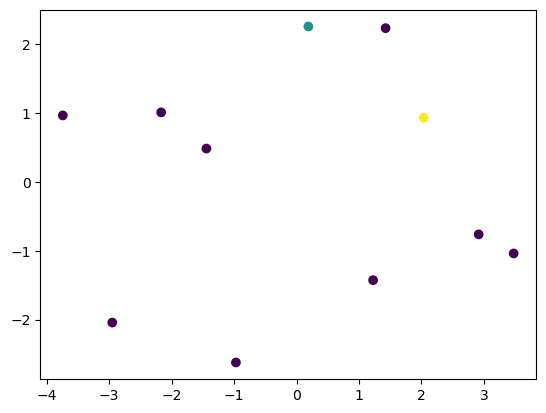

In [99]:
plt.scatter(x_pca[:,0], x_pca[:,1], c=df_encoded_no_na['fighter1_result'])